# Part II - Airline on-time performance - Exploration
## by Juanita Smith

## Introduction
Have you ever been stuck in an airport because your flight was delayed or cancelled and wondered if you could have predicted it if you'd had more data? This is our chance to find out.

This analysis will be focused on predicting flight delays or cancellations.

> This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from 1987 to 2008.
> - See more information from the data expo challenge in 2009 [here](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009).
> - See a full description of the features [here](https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D.)
> - Data can be downloaded from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7).

Dictionary:
1) Year: 1987-2008 
2) Month: 1-12 
3) DayofMonth: 1-31 
4) DayOfWeek: 1 (Monday) - 7 (Sunday) 
5) DepTime: actual departure time from gate (local, hhmm) 
6) CRSDepTime: scheduled departure time from gate (local, hhmm) 
7) ArrTime: actual arrival time at gate (local, hhmm) 
8) CRSArrTime: scheduled arrival time at date (local, hhmm) 
9) UniqueCarrier: unique carrier code 
10) FlightNum: flight number 
11) TailNum: plane tail number 
12) ActualElapsedTime: The time computed from gate departure time to gate arrival time in minutes
13) CRSElapsedTime: The time computed from gate departure time to gate arrival time in minutes
14) AirTime: in minutes 
15) ArrDelay: arrival delay, in minutes 
16) DepDelay: departure delay, in minutes 
17) Origin: origin IATA airport code 
18) Destination: IATA airport code 
19) Distance: in miles 
20) TaxiIn: The time elapsed between wheels down and arrival at the destination airport gate in minutes
21) TaxiOut: The time elapsed between departure from the origin airport gate and wheels off in minutes
22) Cancelled: 1 = yes, 0 = no 
23) CancellationCode: reason for cancellation (A = carrier, B = weather, C = NAS, D = security) 
24) Diverted: 1 = yes, 0 = no 
25) CarrierDelay: subcategory of arrDelay in minutes
26) WeatherDelay: subcategory of arrDelay in minutes 
27) NASDelay: subcategory of arrDelay in minutes 
28) SecurityDelay: subcategory of arrDelay in minutes 
29) LateAircraftDelay: subcategory of arrDelay in minutes


**Important to note:** According to the documentation, a late flight is defined as a flight arriving or departing 15 minutes or more after the scheduled time.

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  





Important points:

- When a flight is cancelled, there are lots of missing values in departure and arrival related fields, as the flight never took off
- When a flight is diverted, columns related to departed are captured, whilst colums related to arrival are missing.
- A flight is considered delayed if arrival delay (arrDelay) >= 15 minutes
- Reasons for delay will only be captured if arrival delay > 15 minutes

In [63]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
import time
import glob

# clear the garbage to free memory as we are working with huge datasets
import gc 

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from src.utils import reduce_mem_usage, create_folder, change_width

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_colwidth', 400)


# stop scientific notation on graphs
#pd.options.display.float_format = '{:.02}'.format


from pylab import rcParams
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [2]:
def set_plot_defaults():
    
    # set plot style
    sns.set_style("whitegrid")
    
    # teal blue
    BASE_COLOR = '#196689'

    #red
    BASE_HIGHLIGHT_INTENSE = sns.color_palette("vlag_r", 9)[0]
    BASE_HIGHLIGHT = sns.color_palette("vlag_r", 9)[2]

    #yellow
    BASE_COMPLEMENTRY = sns.color_palette("husl", 15)[3]

    #grey - used for comparison to all flights
    BASE_GREY = 'lightgrey'

    BASE_COLOR_ARR = sns.color_palette("vlag_r", 9)[8]
    BASE_COLOR_DEP = sns.color_palette("vlag_r", 9)[6]   
    
    # up and down arrows for growth indicators
    SYMBOLS = [u'\u25BC', u'\u25B2'] 
    
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    # fig = plt.figure()
    # fig.rcParams('suptitle', fontsize=20)

    plt.rc('font', size=SMALL_SIZE, weight='ultralight', family='sans-serif')          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE, titlecolor='black', titleweight='bold', labelsize=MEDIUM_SIZE, labelcolor='black', labelweight='ultralight')     # axes title
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold", figsize=[8,4])  # fontsize of the figure title    
    
#     rcParams.update({
#         "font.weight": "ultralight",  # bold fonts
#         "tick.labelsize": 8,   # large tick labels
#         "lines.linewidth": 1,   # thick lines
# #         "lines.color": "k",     # black lines
# #         "grid.color": "0.5",    # gray gridlines
# #         "grid.linestyle": "-",  # solid gridlines
# #         "grid.linewidth": 0.5,  # thin gridlines
#         "savefig.dpi": 300,     # higher resolution output.
#     })

    return BASE_COLOR,  BASE_HIGHLIGHT_INTENSE,  BASE_HIGHLIGHT,  BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS

In [3]:
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = set_plot_defaults()

In [4]:
# rcParams.keys()

In [5]:
# sns.set_style("whitegrid")
# # BASE_COLOR = sns.color_palette("BrBG")[-2]
# BASE_COLOR = '#196689'

# #red
# BASE_HIGHLIGHT = '#e67f83'

# #yellow
# BASE_COMPLEMENTRY = sns.color_palette("husl", 15)[3]

# BASE_COLOR_ARR = '#2A5876'
# BASE_COLOR_DEP = '#6c92ab'

# # 


# # lovely yellow color
# # BASE_COLOR_DEP = sns.color_palette("husl", 15)[3]

# # 0 = down arrow, 1 = up arrow for growth and shrink indicators
# SYMBOLS = [u'\u25BC', u'\u25B2'] 

# # default plot size
# # plt.rcParams['figure.figsize'] = 12,4

# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# # fig = plt.figure()
# # fig.rcParams('suptitle', fontsize=20)

# plt.rc('font', size=SMALL_SIZE, weight='ultralight', family='sans-serif')          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE, titlecolor='black', titleweight='bold', labelsize=MEDIUM_SIZE, labelcolor='black', labelweight='ultralight')     # axes title
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold", figsize=[8,4])  # fontsize of the figure title
# # plt.rc('axes', labelsize=16, titlesize=16
# # plt.rcParams['font.family'] = 'Serif'
# # plt.rc('text')
# # plt.rcParams['xtick.labelsize']=8

# # # mpl.rcParams['lines.linewidth'] = 2
# # # mpl.rcParams['lines.linestyle'] = '--'

# # # plt.rcParams.update({
# # #     "font.weight": "bold",
# # #     "xtick.major.size": 5,
# # #     "xtick.major.pad": 7,
# # #     "xtick.labelsize": 15,
# # #     "grid.color": "0.5",
# # #     "grid.linestyle": "-",
# # #     "grid.linewidth": 5,
# # #     "lines.linewidth": 2,
# # #     "lines.color": "g",
# # # })

In [6]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 14

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# matplotlib.rcParams.update({'font.size': 22})
# matplotlib.rc('font', **font)

# plt.title("Simple plot", fontdict={'fontweight': 'normal', 'weight': 'normal', 'family': 'sans-serif'})

In [7]:
FILE_NAME_RAW = '../data/flights_raw.pkl'
FILE_NAME_CLEAN = '../data/flights_clean.pkl'
FILE_NAME_ENHANCED = '../data/flights_enhanced.pkl'

In [8]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
sns.color_palette("husl", 15)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9542900080364486, 0.4779505175890752, 0.1963917622115608),
 (0.7930046244373694, 0.5708100522446624, 0.19489531984381053),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.5571803870240879, 0.6507747739933957, 0.19331667588333168),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.20774052347943134, 0.6813852191365138, 0.6002900398972028),
 (0.21316806282417172, 0.6731234926210208, 0.6838056741516414),
 (0.21979956608283252, 0.6625157876850336, 0.7732093159317208),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5830408541921136, 0.5695319215803094, 0.9583591966369759),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.9596479078308885, 0.3748291312853888, 0.8930044537663009),
 (0.9642903119819891, 0.41420146582831974, 0.7188681186026104)]

In [10]:
test = sns.color_palette("Paired")
test

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [11]:
sns.color_palette("BrBG")

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.9636293733179546, 0.9237985390234525, 0.8185313341022683),
 (0.8299115724721262, 0.9294886582083814, 0.9152633602460593),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

In [12]:
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [13]:
sns.color_palette("vlag_r", 9)

[(0.73278943, 0.36956954, 0.36476549),
 (0.79842217, 0.5216578, 0.51146173),
 (0.85899928, 0.66937226, 0.6596292),
 (0.92704736, 0.82865028, 0.82181656),
 (0.97978484, 0.96222949, 0.95935496),
 (0.84921192, 0.86135782, 0.89626076),
 (0.68441395, 0.73612771, 0.82136094),
 (0.52753571, 0.62574126, 0.77013939),
 (0.35551826, 0.51744353, 0.73994642)]

In [14]:
# blue
# #93c6e6

# matching complimentary
# #e6b093

In [15]:
# # BASE_COLOR = sns.color_palette("vlag_r", 9)[8]

# # #red
# BASE_HIGHLIGHT_INTENSE = sns.color_palette("vlag_r", 9)[0]
# BASE_HIGHLIGHT = sns.color_palette("vlag_r", 9)[2]

# #yellow
# BASE_COMPLEMENTRY = sns.color_palette("husl", 15)[3]

# #grey - used for comparison to all flights
# BASE_GREY = 'lightgrey'

# BASE_COLOR_ARR = sns.color_palette("vlag_r", 9)[8]
# BASE_COLOR_DEP = sns.color_palette("vlag_r", 9)[6]

### Get data

In [16]:
# load the cleaned file 
flights = pd.read_pickle(FILE_NAME_CLEAN)
flights.sample(5)

year  month  dayofMonth  dayOfWeek         depTime      CRSDepTime  \
21339202  2006      1          29          7 0 days 19:21:00 0 days 19:20:00   
12142072  2004     10          26          2 0 days 08:45:00 0 days 08:43:00   
14355678  2005      2          24          4 0 days 13:31:00 0 days 13:30:00   
34804603  2007     12          22          6 0 days 11:25:00 0 days 11:10:00   
34246909  2007     11           7          3 0 days 09:59:00 0 days 10:05:00   

                 arrTime      CRSArrTime uniqueCarrier  flightNum tailNum  \
21339202 0 days 23:04:00 0 days 23:17:00            DL       2020  N6716C   
12142072 0 days 10:24:00 0 days 10:33:00            DL        283  N104DA   
14355678 0 days 16:36:00 0 days 16:27:00            NW       1270  N371NB   
34804603 0 days 13:42:00 0 days 13:40:00            WN         31  N453WN   
34246909 0 days 11:11:00 0 days 11:25:00            XE       2768  N15948   

          actualElapsedTime  CRSElapsedTime  airTime  arrDelay  depDelay  \
21339202              404.0           417.0    346.0       0.0       1.0   
12142072               99.0           110.0     69.0       0.0       2.0   
14355678              185.0           177.0    148.0       9.0       1.0   
34804603               77.0            90.0     71.0       2.0      15.0   
34246909               72.0            80.0     57.0       0.0       0.0   

         origin dest  distance  taxiIn  taxiOut  cancelled cancellationCode  \
21339202    JFK  SFO      2586     6.0     52.0      False              NaN   
12142072    ATL  PBI       545     5.0     25.0      False              NaN   
14355678    MSP  IAH      1034     6.0     31.0      False              NaN   
34804603    ELP  DAL       562     1.0      5.0      False              NaN   
34246909    IAH  LIT       374     7.0      8.0      False              NaN   

          diverted  carrierDelay  weatherDelay  NASDelay  securityDelay  \
21339202     False           0.0           0.0       0.0            0.0   
12142072     False           0.0           0.0       0.0            0.0   
14355678     False           0.0           0.0       0.0            0.0   
34804603     False           0.0           0.0       0.0            0.0   
34246909     False           0.0           0.0       0.0            0.0   

          lateAircraftDelay  
21339202                0.0  
12142072                0.0  
14355678                0.0  
34804603                0.0  
34246909                0.0

In [17]:
# make sure datatypes were preserved from cleaning step
flights.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701228 entries, 0 to 37742759
Data columns (total 29 columns):
 #   Column             Non-Null Count     Dtype          
---  ------             --------------     -----          
 0   year               37701228 non-null  int16          
 1   month              37701228 non-null  int8           
 2   dayofMonth         37701228 non-null  int8           
 3   dayOfWeek          37701228 non-null  int8           
 4   depTime            36991149 non-null  timedelta64[ns]
 5   CRSDepTime         37701228 non-null  timedelta64[ns]
 6   arrTime            36913965 non-null  timedelta64[ns]
 7   CRSArrTime         37701228 non-null  timedelta64[ns]
 8   uniqueCarrier      37701228 non-null  object         
 9   flightNum          37701228 non-null  int16          
 10  tailNum            37632291 non-null  object         
 11  actualElapsedTime  36913965 non-null  float16        
 12  CRSElapsedTime     37700823 non-null  float16        


In [18]:
flights.shape

(37701228, 29)

In [353]:
# get carrier descriptions
carriers = pd.read_csv('../data/lookup_tables/carriers.csv', index_col='Code')
carriers = carriers.rename(columns={'Description': 'carrier_description'})
carriers.index.name = 'uniqueCarrier'
carriers.fillna('unknown', axis=1, inplace=True)
carriers.sample(5)

carrier_description
uniqueCarrier                                               
BHO                                     Bighorn Airways Inc.
M6                                    Amerijet International
JAG            JetAlliance Flugbetriebs d/b/a JAF Airservice
COK                                      Coker Aviation Inc.
MTA                                Arkansas Traveler Airline

In [20]:
# get airplane data
planes = pd.read_csv('../data/lookup_tables/plane-data.csv', index_col='tailnum')
planes.fillna('unknown', axis=1, inplace=True)
planes.sample(10)

type      manufacturer  issue_date        model   status  \
tailnum                                                                    
N16234   Corporation            BOEING  08/06/1999      737-824    Valid   
N915AT   Corporation            BOEING  04/16/2001      717-200    Valid   
N37178   Corporation          CANADAIR  06/26/1997  CL-600-2B19    Valid   
N528JB   Corporation  AIRBUS INDUSTRIE  06/19/2008     A320-232    Valid   
N754SK   Corporation    BOMBARDIER INC  09/30/2005  CL-600-2C10    Valid   
N3741S   Corporation            BOEING  01/30/2001      737-832    Valid   
N4WAAA       unknown           unknown     unknown      unknown  unknown   
N427WN   Corporation            BOEING  11/13/2002      737-7H4    Valid   
N994AT   Corporation            BOEING  11/05/2002      717-200    Valid   
N684JW   Corporation           EMBRAER  08/09/2004    EMB-145LR    Valid   

                   aircraft_type engine_type     year  
tailnum                                                
N16234   Fixed Wing Multi-Engine   Turbo-Fan     1999  
N915AT   Fixed Wing Multi-Engine   Turbo-Fan     2001  
N37178   Fixed Wing Multi-Engine   Turbo-Jet     1997  
N528JB   Fixed Wing Multi-Engine   Turbo-Jet     2001  
N754SK   Fixed Wing Multi-Engine   Turbo-Fan     2005  
N3741S   Fixed Wing Multi-Engine   Turbo-Jet     2001  
N4WAAA                   unknown     unknown  unknown  
N427WN   Fixed Wing Multi-Engine   Turbo-Fan     2002  
N994AT   Fixed Wing Multi-Engine   Turbo-Fan     2002  
N684JW   Fixed Wing Multi-Engine   Turbo-Fan     2004

In [21]:
planes = planes.rename(columns={'type': 'plane_type'})

In [22]:
planes.status.value_counts()

Valid                4479
unknown               549
Registered to Mfr       1
Name: status, dtype: int64

In [23]:
# drop columns not needed
planes.drop('status', axis=1, inplace=True)

In [24]:
# check and drop rows that contain only missing values
# planes = planes.loc[planes.isna().mean(axis=1) <= 0.4, :]

In [25]:
# get airport descriptions
airports = pd.read_csv('../data/lookup_tables/airports.csv', index_col='iata')
airports.fillna('unknown', axis=1, inplace=True)

# drop columns not interesting for 
airports.sample(10)

airport         city state country        lat  \
iata                                                                         
AGZ                 Wagner Municipal       Wagner    SD     USA  43.063327   
RNT                 Renton Municipal       Renton    WA     USA  47.493139   
HVE                       Hanksville   Hanksville    UT     USA  38.418037   
FPR   St. Lucie County International   Ft. Pierce    FL     USA  27.495056   
ISP          Long Island - MacArthur        Islip    NY     USA  40.795243   
BFW             Silver Bay Municipal   Silver Bay    MN     USA  47.249028   
GSO     Piedmont Triad International   Greensboro    NC     USA  36.097747   
M13   Poplarville-Pearl River County  Poplarville    MS     USA  30.786021   
93B                       Stonington   Stonington    ME     USA  44.175081   
N00                            Maben    Lexington    NY     USA  42.272308   

            long  
iata              
AGZ    -98.29619  
RNT   -122.21575  
HVE  -110.704038  
FPR   -80.368278  
ISP   -73.100212  
BFW   -91.415583  
GSO   -79.937297  
M13   -89.504507  
93B   -68.678637  
N00   -74.394037

In [26]:
airports.country.value_counts()

USA                               3372
Thailand                             1
Palau                                1
N Mariana Islands                    1
Federated States of Micronesia       1
Name: country, dtype: int64

In [27]:
# check and drop rows that contain only missing values
# airports = airports.loc[airports.isna().mean(axis=1) <= 0.4, :]

### Feature engineering

In [28]:
# create a datetime field for time series analysis
flights.rename(columns={'dayofMonth':'day'}, inplace=True)
flights['hour'] = flights['depTime'].dt.components['hours']
flights['date'] = pd.to_datetime(flights[['year', 'month', 'day', 'hour']], yearfirst=True, errors='raise')
flights[['year', 'month', 'day', 'depTime', 'date']].sample(5)

year  month  day         depTime                date
22578631  2006      4   24 0 days 07:00:00 2006-04-24 07:00:00
19528080  2005     10   15 0 days 18:09:00 2005-10-15 18:00:00
19663467  2005     11    6 0 days 20:23:00 2005-11-06 20:00:00
17705064  2005      7   20 0 days 11:22:00 2005-07-20 11:00:00
31530679  2007      6   17 0 days 15:53:00 2007-06-17 15:00:00

In [29]:
# build a flight .status field to compare cancelled, diverted, ontime and delayed flights
flights['flight_status'] = np.where(flights['cancelled'] == True, 'cancelled',
                           np.where(flights['diverted'] == True, 'diverted',
                           np.where((flights['cancelled'] == False) & (flights['diverted'] == False) & (flights['arrDelay'] >= 15), 'delayed',    
                           np.where((flights['cancelled'] == False) & (flights['diverted'] == False) & (flights['arrDelay'] < 15), 'on_time', np.nan))))  

flights['flight_status'].value_counts()

on_time      28987264
delayed       7926701
cancelled      710079
diverted        77184
Name: flight_status, dtype: int64

In [30]:
# add new 'lane' feature consisting of both departure and arrival airport
flights['lane'] = flights['origin'] + '-' + flights['dest']

In [32]:
# drop columns that will not be used further for this analysis
cols_to_drop = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'flightNum']
flights.drop(cols_to_drop, axis=1, inplace=True)

In [33]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701228 entries, 0 to 37742759
Data columns (total 29 columns):
 #   Column             Dtype          
---  ------             -----          
 0   year               int16          
 1   month              int8           
 2   day                int8           
 3   dayOfWeek          int8           
 4   depTime            timedelta64[ns]
 5   arrTime            timedelta64[ns]
 6   uniqueCarrier      object         
 7   tailNum            object         
 8   actualElapsedTime  float16        
 9   airTime            float16        
 10  arrDelay           float16        
 11  depDelay           float16        
 12  origin             object         
 13  dest               object         
 14  distance           int16          
 15  taxiIn             float16        
 16  taxiOut            float16        
 17  cancelled          bool           
 18  cancellationCode   object         
 19  diverted           bool           
 20  

In [34]:
# save the enhanced flight file as pickle file
flights.to_pickle(FILE_NAME_ENHANCED)

In [35]:
# clear the garbage to free memory
gc.collect()

20

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


In [36]:
# reload the enhanced flight file 
flights = pd.read_pickle(FILE_NAME_ENHANCED)
flights.sample(5)

year  month  day  dayOfWeek         depTime         arrTime  \
30310560  2007      4   10          2 0 days 12:55:00 0 days 13:49:00   
32873447  2007      8   15          3 0 days 14:47:00 0 days 19:34:00   
16595357  2005      6   22          3 0 days 21:36:00 0 days 22:52:00   
13265238  2004     12    7          2 0 days 15:15:00 0 days 16:41:00   
10925186  2004      8   16          1 0 days 09:46:00 0 days 12:14:00   

         uniqueCarrier tailNum  actualElapsedTime  airTime  arrDelay  \
30310560            CO  N17627               54.0     39.0       0.0   
32873447            CO  N18112              227.0    176.0       9.0   
16595357            UA  N428UA              136.0    120.0      76.0   
13265238            XE  N12934               86.0     67.0       0.0   
10925186            DL  N906DL               88.0     63.0       0.0   

          depDelay origin dest  distance  taxiIn  taxiOut  cancelled  \
30310560       0.0    SAT  IAH       191     5.0     10.0      False   
32873447      27.0    IAH  EWR      1400    19.0     32.0      False   
16595357      84.0    DEN  SMF       910     4.0     12.0      False   
13265238       0.0    JAN  IAH       351     7.0     12.0      False   
10925186       0.0    LIT  ATL       453    13.0     12.0      False   

         cancellationCode  diverted  carrierDelay  weatherDelay  NASDelay  \
30310560              NaN     False           0.0           0.0       0.0   
32873447              NaN     False           0.0           0.0       0.0   
16595357              NaN     False           0.0           0.0       0.0   
13265238              NaN     False           0.0           0.0       0.0   
10925186              NaN     False           0.0           0.0       0.0   

          securityDelay  lateAircraftDelay  hour                date  \
30310560            0.0                0.0  12.0 2007-04-10 12:00:00   
32873447            0.0                0.0  14.0 2007-08-15 14:00:00   
16595357            0.0               76.0  21.0 2005-06-22 21:00:00   
13265238            0.0                0.0  15.0 2004-12-07 15:00:00   
10925186            0.0                0.0   9.0 2004-08-16 09:00:00   

         flight_status     lane  
30310560       on_time  SAT-IAH  
32873447       on_time  IAH-EWR  
16595357       delayed  DEN-SMF  
13265238       on_time  JAN-IAH  
10925186       on_time  LIT-ATL

#### Let's get a first impression of how many flights are ontime, delayed, cancelled or diverted

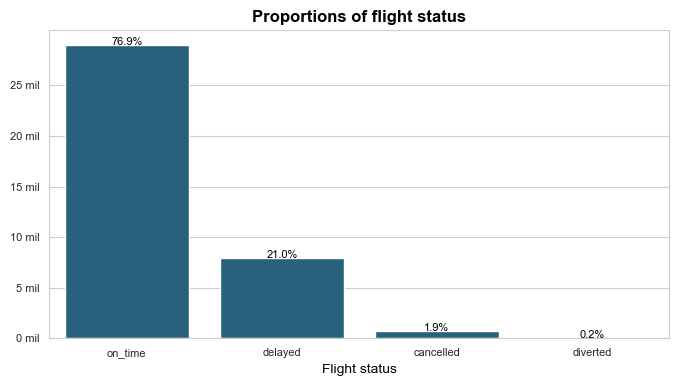

In [37]:
# calculate number of flights per flight status and plot it
flight_status_summary = flights['flight_status'].value_counts(normalize=True)
flight_status = flights['flight_status'].value_counts()
sns.barplot(x=flight_status.index, y=flight_status, color=BASE_COLOR)
plt.ylabel('')
plt.xlabel('Flight status')
plt.title('Proportions of flight status')

locs, labels = plt.xticks()

# for each bar, print a % text at the top of each bar
for loc, label in zip(locs,labels):
    count = flight_status[label.get_text()]
    perc = flight_status_summary[label.get_text()]
    pct_string = '{:0.1f}%'.format(perc*100)
    plt.text(loc, count+0.01, pct_string, ha='center', color='black', size=8, weight='ultralight')
    
ticks = np.arange(0, flight_status[0], 5000000)
labels = ['{:1.0f} mil'.format(tick/1000000) for tick in ticks]
plt.yticks(ticks,labels)

plt.show()

>Around 77% of flights are on time, where as 21% are delayed. Only 2% of flights are cancelled or diverted which is not therefore not the main concern

### Delay Exploration

#### Start by looking at the distribution of the main variables of interest to predict delays: `arrDelay` and `depDelay`

In [38]:
# Take a closer look at distribution of all flights
flights[['depDelay', 'arrDelay']].describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999]).round(0)

depDelay    arrDelay
count  36991149.0  36913965.0
mean          NaN         NaN
std           NaN         NaN
min           0.0         0.0
25%           0.0         0.0
50%           0.0         0.0
75%           7.0        11.0
85%          20.0        24.0
90%          33.0        38.0
95%          62.0        67.0
99%         146.0       154.0
99.9%       302.0       309.0
max        2600.0      2598.0

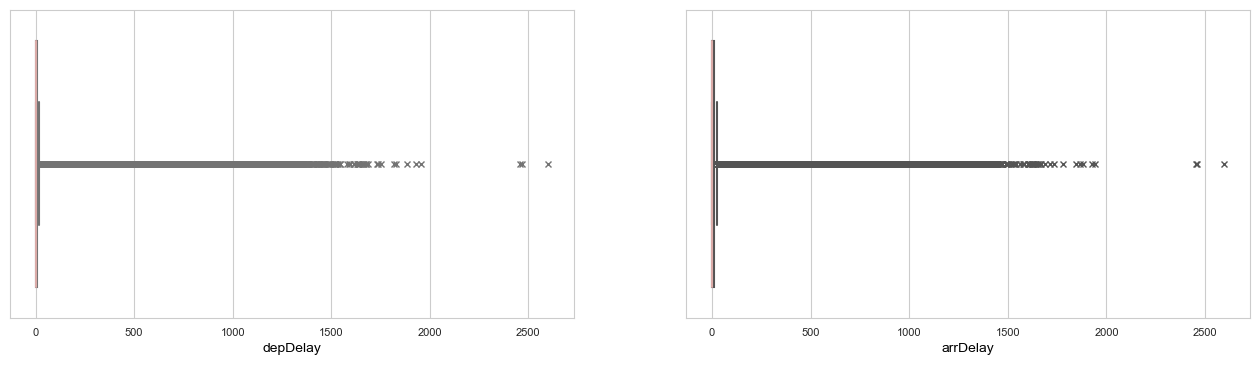

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))   

plt.subplot(1,2,1)
sns.boxplot(data=flights, x='depDelay', color = BASE_COLOR_DEP, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })

plt.subplot(1,2,2)
sns.boxplot(data=flights, x='arrDelay', color = BASE_COLOR_ARR, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })

plt.show()

At 99.999% percentile, we have delays of around 310 minutes, where the max is quite extreme at around 2600 minutes. It's also visible in the box plot that we have severe outliers

Remove all datapoints where departure delay > 310 minutes

In [40]:
# before we drop records make a copy
# flight_delays_all = flight_delays.copy()
# flights_all = flights.copy()

# drop outliers
# get rows to drop where hours are >= 2400
rows_to_drop = flights.loc[(flights['depDelay'] >= 310) | (flights['arrDelay'] >= 310)]
flights.drop(index=rows_to_drop.index, inplace=True)

# # drop outliers
# flight_delays = flight_delays.loc[(flight_delays['depDelay'] <= 250) & (flight_delays['arrDelay'] <= 250)]
# flight_ontime = flight_ontime.loc[(flight_ontime['depDelay'] <= 250) & (flight_ontime['arrDelay'] <= 250)]
# flights = flights.loc[(flights['depDelay'] <= 250) & (flights['arrDelay'] <= 250) & (flights['arrDelay'].notNull())]

In [41]:
# extract delayed and ontime flights into seperate datasets
flight_delays = flights.loc[flights['flight_status'] == 'delayed'].copy()
flight_ontime = flights.loc[flights['flight_status'] == 'on_time'].copy()

In [42]:
# get all columns of type float
float_columns = list(flight_delays.select_dtypes(include=['float16']).columns)

# convert all float columns to int16, which should now be possible as cancelled and diverted data had a lot of missing values in
flight_delays[float_columns] = flight_delays[float_columns].astype('int16')
flight_ontime[float_columns] = flight_ontime[float_columns].astype('int16')

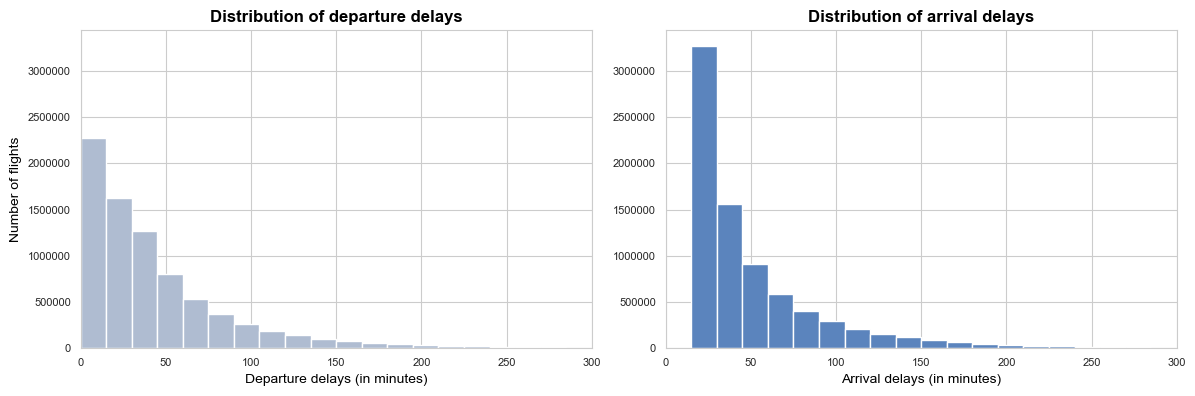

In [43]:
plt.figure(figsize=[12,4])

xbins = np.arange(0, flight_delays['arrDelay'].max()+15, 15)

# plot 1 - distribution of departure delays
ax1 = plt.subplot(1, 2, 1)
ax1.hist(data=flight_delays, x='depDelay', bins=xbins, color=BASE_COLOR_DEP)

plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Number of flights')
plt.xlim(0, 300)
plt.title('Distribution of departure delays')

# plot 2 - distribution of arrival delays
ax2 = plt.subplot(1, 2, 2, sharey=ax1, sharex=ax1)
ax2.hist(data=flight_delays, x='arrDelay', bins=xbins, color=BASE_COLOR_ARR)
plt.xlabel('Arrival delays (in minutes)')
plt.title('Distribution of arrival delays')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

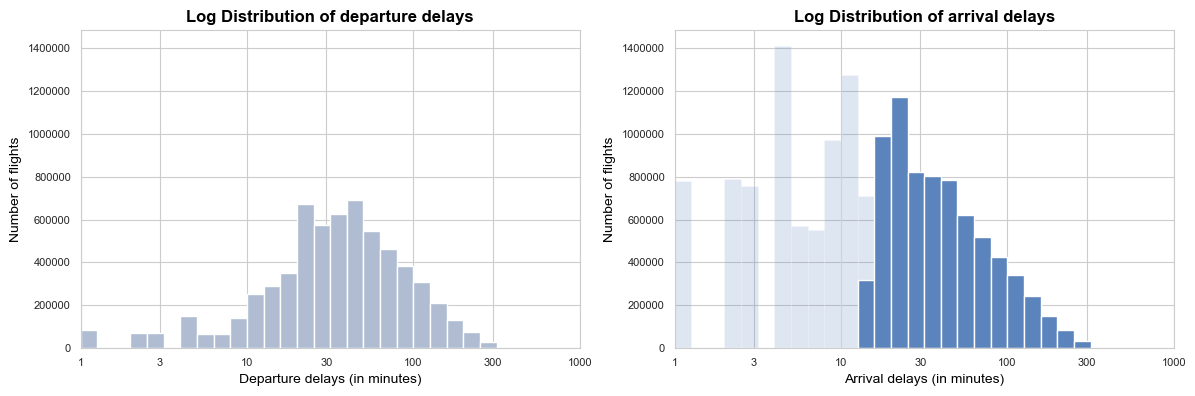

In [66]:
# As the distribution of delays are right skewed, lets plot a log distribution instead

plt.figure(figsize=[12,4])

log_binsize = 0.1
bins= 10 ** np.arange(0, np.log10(flight_delays['arrDelay'].max())+log_binsize, log_binsize)
ticks = [1, 3, 10, 30, 100, 300, 1000]
labels = ['{}'.format(tick) for tick in ticks]

ax2 = plt.subplot(1, 2, 2)
plt.hist(data=flight_ontime, x='arrDelay', bins=bins, color=BASE_COLOR_ARR, alpha=0.2)
plt.hist(data=flight_delays, x='arrDelay', bins=bins, color=BASE_COLOR_ARR)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Arrival delays (in minutes)')
plt.ylabel('Number of flights')
plt.title('Log Distribution of arrival delays')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(1, 300)

ax1 = plt.subplot(1, 2, 1, sharex=ax2, sharey=ax2)
plt.hist(data=flight_delays, x='depDelay', bins=bins, color=BASE_COLOR_DEP)
plt.xticks(ticks, labels)
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Number of flights')
plt.title('Log Distribution of departure delays')
plt.ticklabel_format(style='plain', axis='y')
# plt.xlim(1, 300)

plt.tight_layout()

>Both departure and arrival delays are right skewed. When plotted on a log scale, arrival delays are still right skewed whilst departure delays are more normally distributed.
Arrival delays were restricted to >= 15 minutes, which was not the case for departure delays, otherwise departure delays would also be right skewed.

>Most arrivals are around 20 minutes late. There is a steep decline in delays > 20 minutes.

#### What are the main reasons for delays ?

In [45]:
# drop records where all delay reasons are 0, means reasons are not available
delay_reasons = flight_delays.loc[flight_delays[['carrierDelay','weatherDelay','NASDelay','securityDelay','lateAircraftDelay']].sum(axis=1) != 0]

In [46]:
# calculate the mean minutes and proportion of each reason
delay_reason_melt = pd.melt(delay_reasons, value_vars = ['carrierDelay','weatherDelay','NASDelay','securityDelay','lateAircraftDelay'], value_name='minutes')
delay_reason_melt = delay_reason_melt.groupby('variable')['minutes'].agg(['sum', 'mean'])
delay_reason_melt['perc'] = delay_reason_melt['sum']/delay_reason_melt['sum'].sum()*100
delay_reason_melt.sort_values(by='perc', ascending=False, inplace=True)
delay_reason_melt.head()

sum       mean       perc
variable                                          
lateAircraftDelay  138871488  18.551466  36.092073
NASDelay           120850739  16.144123  31.408561
carrierDelay       102318718  13.668480  26.592173
weatherDelay        21893841   2.924739   5.690110
securityDelay         835270   0.111581   0.217083

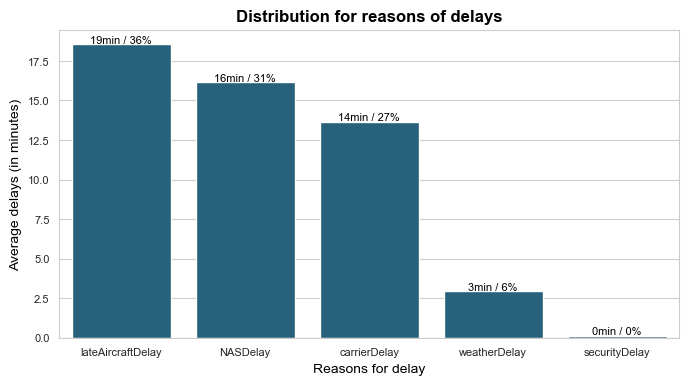

In [47]:
sns.barplot(data=delay_reason_melt, x=delay_reason_melt.index, y='mean', color=BASE_COLOR)

plt.title('Distribution for reasons of delays')
plt.xlabel('Reasons for delay')
plt.ylabel('Average delays (in minutes)')

# for each bar, print % of total delay at the top of each bar
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):
    bar = delay_reason_melt.loc[label.get_text()]
    pct_string = '{:0.0f}min / {:0.0f}%'.format(bar['mean'], bar['perc'])
    plt.text(loc, bar['mean']+0.1, pct_string, ha='center', color='black', size=8, weight='ultralight')

plt.show()

>The top 3 reasons for delays are caused by late aircrafts, NAS, and carriers
>- 36% of delays are caused by late aircrafts with an average of 18 minutes delay
>- 32% of delays are caused by NAS with an average of 16 minutes delay
>- 26% of delays are caused by carriers with an avrage of 13 minutes delay
>- Weather and security cause only 6% of all delays

#### How are top 3 reasons for delay distributed ?

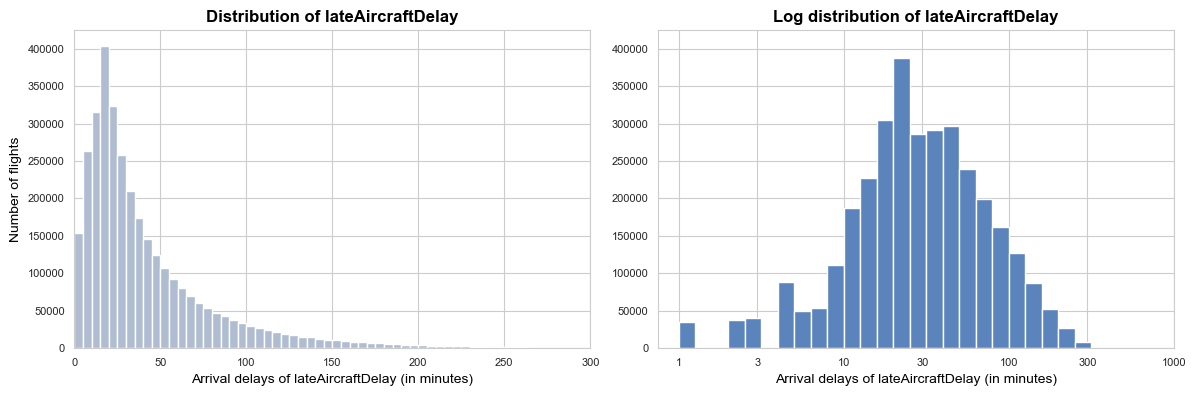

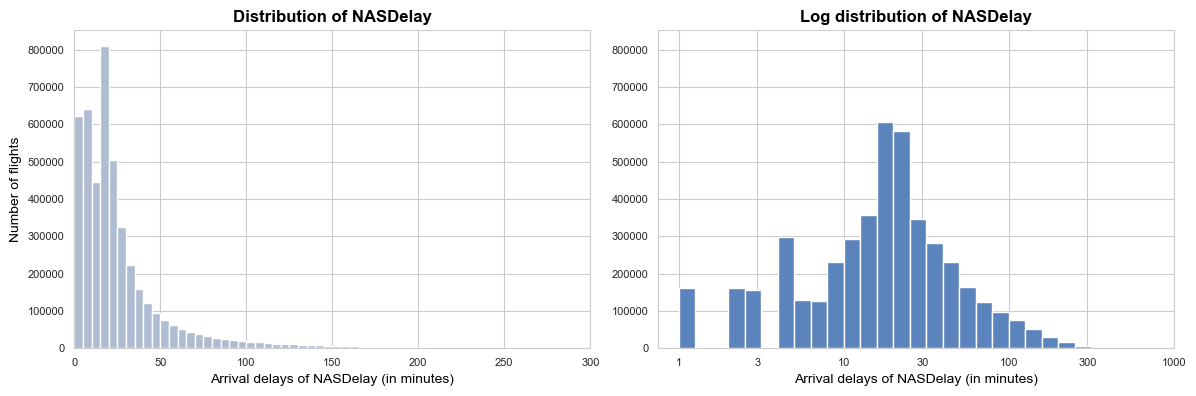

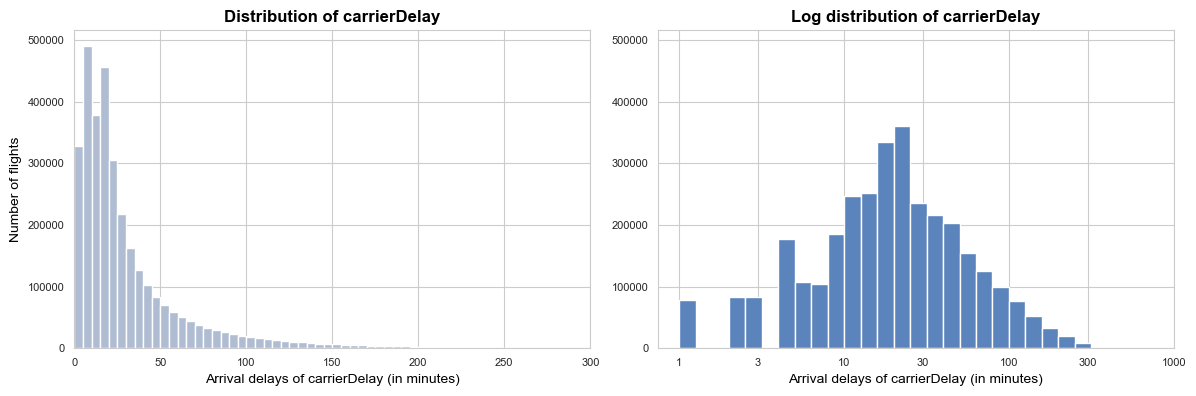

In [65]:
for col in ['lateAircraftDelay', 'NASDelay', 'carrierDelay']:
     
    plt.figure(figsize=[12,4])  
    
    # plot 2 - log distribution for reason of delay
    ax2 = plt.subplot(1, 2, 2)    
       
    log_binsize = 0.1
    bins= 10 ** np.arange(0, np.log10(delay_reasons[col].max())+log_binsize, log_binsize)
    ticks = [1, 3, 10, 30, 100, 300, 1000]
    labels = ['{}'.format(tick) for tick in ticks]

    plt.hist(data=delay_reasons, x=col, bins=bins, color=BASE_COLOR_ARR)
    plt.xscale('log')
    plt.xticks(ticks,labels)
    plt.xlabel('Arrival delays of {} (in minutes)'.format(col))
    plt.title('Log distribution of {}'.format(col))    
    
    # plot 1 - distribution of reason for delay
    xbins = np.arange(0, delay_reasons[col].max()+5, 5)

    ax1 = plt.subplot(1, 2, 1, sharey=ax2)
    plt.hist(data=delay_reasons.loc[delay_reasons[col] > 0], x=col, bins=xbins, color=BASE_COLOR_DEP)
      
    plt.xlabel('Arrival delays of {} (in minutes)'.format(col))
    plt.ylabel('Number of flights')
    plt.xlim(0, 300)
    plt.title('Distribution of {}'.format(col))
    
    plt.tight_layout()

>Late aircrafts, NAS and carrier delays are all right skewed, with a normal distribution on log scale. The mean delay on log scale are around 20-25 min

#### When is the best time of day/day of week/time of year to fly to minimise delays?

Build a time series to view flight and delay patterns at different period intervals to discover possible trends and peaks

In [49]:
# build a timeseries dataset with datatime field as index
flight_timeseries_day = flights.groupby('date')['flight_status'].value_counts().unstack()
flight_timeseries_day['total_flights'] = flight_timeseries_day.sum(axis=1)
flight_timeseries_day['diff_delay'] = flight_timeseries_day['delayed'].diff()
flight_timeseries_day['pct_delay'] = flight_timeseries_day['delayed'].pct_change()
flight_timeseries_day.head()

flight_status        delayed  diverted  on_time  total_flights  diff_delay  \
date                                                                         
2003-01-01 00:00:00      6.0       NaN     25.0           31.0         NaN   
2003-01-01 01:00:00      5.0       NaN     14.0           19.0        -1.0   
2003-01-01 02:00:00      NaN       NaN      3.0            3.0         NaN   
2003-01-01 03:00:00      1.0       NaN      NaN            1.0         NaN   
2003-01-01 04:00:00      NaN       NaN      1.0            1.0         NaN   

flight_status        pct_delay  
date                            
2003-01-01 00:00:00        NaN  
2003-01-01 01:00:00  -0.166667  
2003-01-01 02:00:00   0.000000  
2003-01-01 03:00:00  -0.800000  
2003-01-01 04:00:00   0.000000

In [50]:
flight_timeseries_day.tail()

flight_status        delayed  diverted  on_time  total_flights  diff_delay  \
date                                                                         
2008-04-30 19:00:00    200.0       1.0   1004.0         1205.0        27.0   
2008-04-30 20:00:00    167.0       NaN    659.0          826.0       -33.0   
2008-04-30 21:00:00    119.0       NaN    607.0          726.0       -48.0   
2008-04-30 22:00:00     52.0       NaN    212.0          264.0       -67.0   
2008-04-30 23:00:00     17.0       NaN     69.0           86.0       -35.0   

flight_status        pct_delay  
date                            
2008-04-30 19:00:00   0.156069  
2008-04-30 20:00:00  -0.165000  
2008-04-30 21:00:00  -0.287425  
2008-04-30 22:00:00  -0.563025  
2008-04-30 23:00:00  -0.673077

>2008 does not contain data for the full year, only Jan - April is available. Drop this year from all data

In [51]:
flight_timeseries_day = flight_timeseries_day.loc[flight_timeseries_day.index.year < 2008]
flights = flights.loc[flights['year'] < 2008]
flight_delays = flight_delays.loc[flight_delays['year'] < 2008]
flight_ontime = flight_ontime.loc[flight_ontime['year'] < 2008]

#### Let's start by looking of the distribution of flights vs delays per year

In [52]:
# create a yearly time series
freq = 'Y'
flight_timeseries_year = flight_timeseries_day.resample(freq).sum()
flight_timeseries_year['pct_delay'] = flight_timeseries_year['delayed'].pct_change()
flight_timeseries_year['pct_all'] = flight_timeseries_year['total_flights'].pct_change()

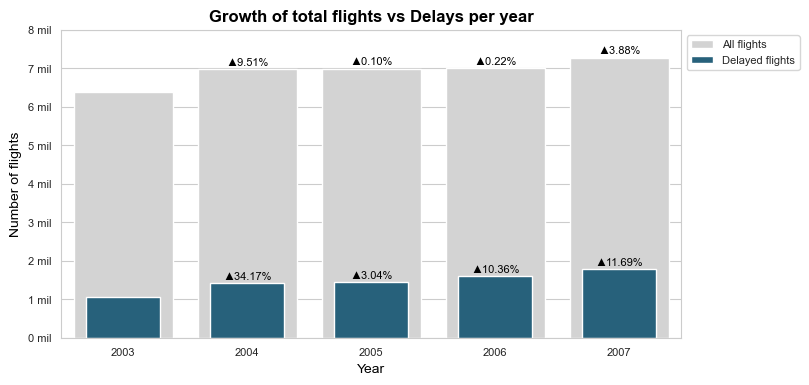

In [53]:
plt.figure(figsize=[8,4])

sns.barplot(data=flight_timeseries_year, x=flight_timeseries_year.index.year, y='total_flights', color=BASE_GREY, label='All flights')
sns.barplot(data=flight_timeseries_year, x=flight_timeseries_year.index.year, y='delayed', color=BASE_COLOR, label='Delayed flights', width=0.6)

# for each blue bar, print % delays over total flights year on year 
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):
    date = pd.to_datetime(label.get_text()).strftime('%Y')
    date = date + '-12-31'
    counts = flight_timeseries_year.loc[date]
    
    # add positive or negative sign
    symbol = ''
    if pd.isna(counts['pct_delay']):
        continue
    elif counts['pct_delay'] > 0:
        symbol = SYMBOLS[1]
    elif counts['pct_delay'] < 0:
        symbol = SYMBOLS[0]
    
    pct_string_delay = '{}{:0.2f}%'.format(symbol, round(counts['pct_delay']*100,2))
    pct_string_all = '{}{:0.2f}%'.format(symbol, round(counts['pct_all']*100,2))
    plt.text(loc, counts.delayed+100000, pct_string_delay, ha='center', color='black', fontsize=8)
    plt.text(loc, counts.total_flights+100000, pct_string_all, ha='center', color='black', fontsize=8)
    
binsize=1000000
yticks = np.arange(0, flight_timeseries_year['total_flights'].max()+binsize, binsize)
ylabels = ['{:1.0f}'.format(tick/1000000)+' mil' for tick in yticks]
plt.yticks(yticks, ylabels)    

plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.title('Growth of total flights vs Delays per year')
plt.xlabel('Year')
plt.ylabel('Number of flights')

plt.show()

>Both the total number of flights and delays increase every year. The growth rate of delays are higher than flight growth.

#### Can we spot peaks in months ? For example are summer months and xmas causing delays at airports ?

In [54]:
# create a monthly time series
freq = 'M'
flight_timeseries_month = flight_timeseries_day.resample(freq).sum()
flight_timeseries_month['pct_delay'] = flight_timeseries_month['delayed'].pct_change()
flight_timeseries_month['pct_all'] = flight_timeseries_month['total_flights'].pct_change()
flight_timeseries_month['diff_delay'] = flight_timeseries_month['delayed'].diff()
flight_timeseries_month['pct_diff_delay'] = flight_timeseries_month['diff_delay'].pct_change()

In [55]:
def improve_yticks(maxvalue, bins=10):
    
    binsize = maxvalue/bins
    if maxvalue > 4000000:
        ind = 'mil'
        div = 1000000
        binsize=500000
        yticks = np.arange(0, maxvalue+(binsize), binsize)
        ylabels = ['{:1.1f}'.format(tick/div)+ind for tick in yticks]    
    elif maxvalue > 1000000:
        ind = 'mil'
        div = 1000000
        binsize=200000
        yticks = np.arange(0, maxvalue+(binsize), binsize)
        ylabels = ['{:1.1f}'.format(tick/div)+ind for tick in yticks]        
    elif maxvalue > 10000:
        ind = 'k'
        div = 1000   
        yticks = np.arange(0, maxvalue+(binsize), binsize)
        ylabels = ['{:1.0f}'.format(tick/div)+ind for tick in yticks]        
    else:    
        ind = ''
        div = 1          
        yticks = np.arange(0, maxvalue+(binsize), binsize)
        ylabels = ['{:1.0f}'.format(tick/div)+ind for tick in yticks]
        
    return yticks, ylabels, binsize

In [56]:
def plot_period_side_by_side(df, col, annotate=True, title='month', rotate=False, sharey=False):
    
    flight_total = df.groupby(col)['total_flights'].mean().sum()
    delay_total = df.groupby(col)['delayed'].mean().sum()
    
    # Customize annotation
    if rotate:
        plt.figure(figsize=[14,4])        
        weight='ultralight'
        rotation=90
        color='black'
        xytext = (0, 8)
        size=6
    else:
        plt.figure(figsize=[10,4])
        weight='ultralight'
        rotation=None
        color='black'
        xytext = (0, 3)
        size=8        


    # PLOT 2: visualize distribution of ALL flights per selected period
    ax1 = plt.subplot(1,2,2)
    sns.barplot(data=df, x=col, y='total_flights', color=BASE_GREY, label='All flights', errorbar=None, errwidth=1)

    # improve yticks
    maxvalue = df.groupby(col)['total_flights'].mean().max()
    yticks, ylabels, binsize = improve_yticks(maxvalue)           
    plt.yticks(yticks, ylabels)  

    # annote bars with % of total flights
    if annotate:
        for p in ax1.patches:
            ax1.annotate("{:.1%}".format(p.get_height()/flight_total), 
                           (p.get_x() + p.get_width() / 2., 
                            p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = xytext,
                            textcoords = 'offset points',
                            size=7, 
                            weight=weight,
                            color='black',
                            rotation=rotation)  


    plt.title('Average total flights {}'.format(title))
    plt.xlabel(title)
    plt.ylabel('Number of flights')

    
    # PLOT 1: visualize distribution of DELAYED flights per selected period
    
    # control stacking
    if sharey:
        ax2 = plt.subplot(1,2,1, sharey=ax1)
    else:
        ax2 = plt.subplot(1,2,1)   
    
    sns.barplot(data=df, x=col, y='delayed', color=BASE_COLOR, label='Delayed flights', errorbar=None, errwidth=1)

    if not sharey:
        # improve yticks
        maxvalue = df.groupby(col)['delayed'].mean().max()
        yticks, ylabels, binsize = improve_yticks(maxvalue)  
        plt.yticks(yticks, ylabels)  

    # annote bars with % of total flights
    if annotate:
        for p in ax2.patches:
            ax2.annotate("{:.1%}".format(p.get_height()/delay_total), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                            xytext = xytext,
                            textcoords = 'offset points',
                            size=7, 
                            weight=weight,
                            color=color,
                            rotation=rotation)  

    plt.title('Average delayed flights per {}'.format(title))
    plt.xlabel(title)
    plt.ylabel('Number of flights')

    plt.tight_layout()
    plt.show()

In [73]:
def plot_period_stacked(df, col, annotate=True, title='month', rotate=False):
    
    flight_total = df.groupby(col)['total_flights'].mean().sum()
#     delay_total = df.groupby(col)['delayed'].mean().sum()
    
    # Customize annotation
    if rotate:
#         plt.figure(figsize=[14,4])        
        weight='ultralight'
        rotation=90
        color='black'
        xytext = (0, 8)
        size=6
    else:
#         plt.figure(figsize=[10,4])
        weight='ultralight'
        rotation=None
        color='black'
        xytext = (0, 3)
        size=8        

    ax1 = sns.barplot(data=df, x=col, y='total_flights', color=BASE_GREY, label='All flights', errorbar=None, errwidth=1)
    ax2 = sns.barplot(data=df, x=col, y='delayed', color=BASE_COLOR, label='Delayed flights', errorbar=None, errwidth=1, width=0.6) 

    
#   improve yticks
    maxvalue = df.groupby(col)['total_flights'].mean().max()
    yticks, ylabels, binsize = improve_yticks(maxvalue)   
    plt.yticks(yticks, ylabels)  
    
#   annote bars with % of total flights
    if annotate:
        for p in ax2.patches:
            ax2.annotate("{:.1%}".format(p.get_height()/flight_total), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                            xytext = xytext,
                            textcoords = 'offset points',
                            size=7, 
                            weight=weight,
                            color=color,
                            rotation=rotation)  
 

    plt.title('Average total flights for {}'.format(title))
    plt.xlabel(title)
    plt.ylabel('Number of flights')

    plt.tight_layout()
    plt.show()

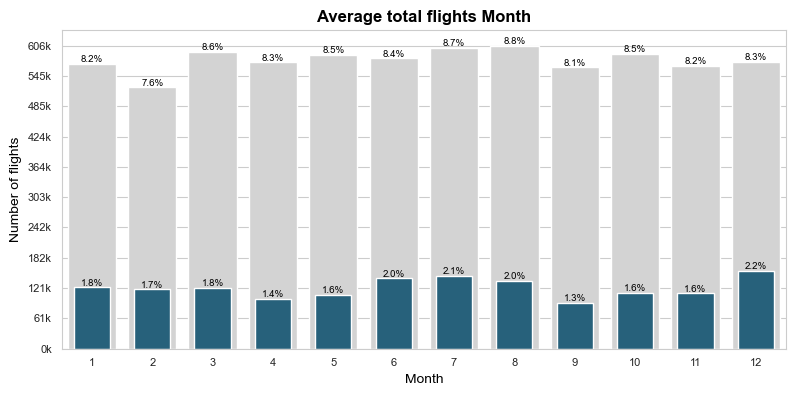

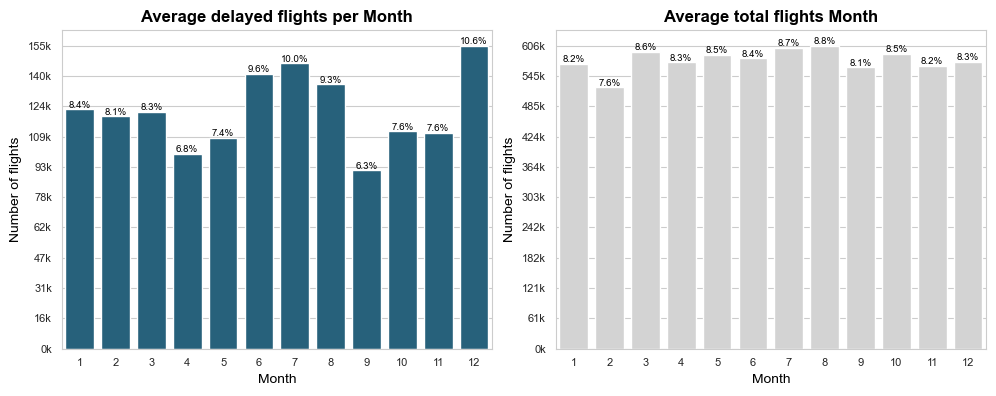

In [69]:
plot_period_stacked(df=flight_timeseries_month, col=flight_timeseries_month.index.month, annotate=True, title='Month', rotate=False)
plot_period_side_by_side(df=flight_timeseries_month, col=flight_timeseries_month.index.month, annotate=True, title='Month', rotate=False, sharey=False)

>The biggest peaks in **delays** are in summer months June-August and xmas period December-March. Delays decrease in spring/autumn months.

>There is not as much variation in the average **total** flights per month, the summer and christmas peaks are not so immediately evidant

#### Can we spot peaks in certain days of the month ? 

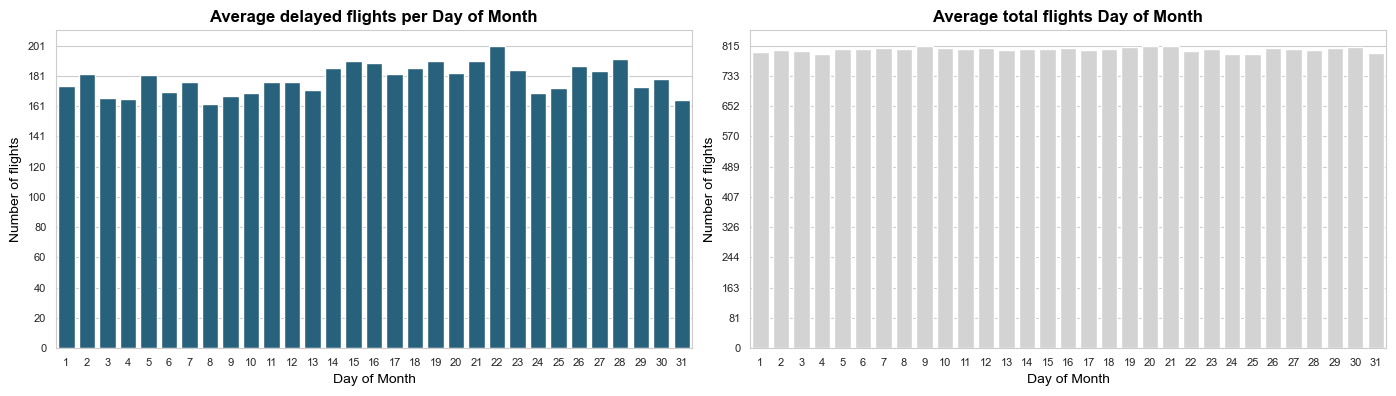

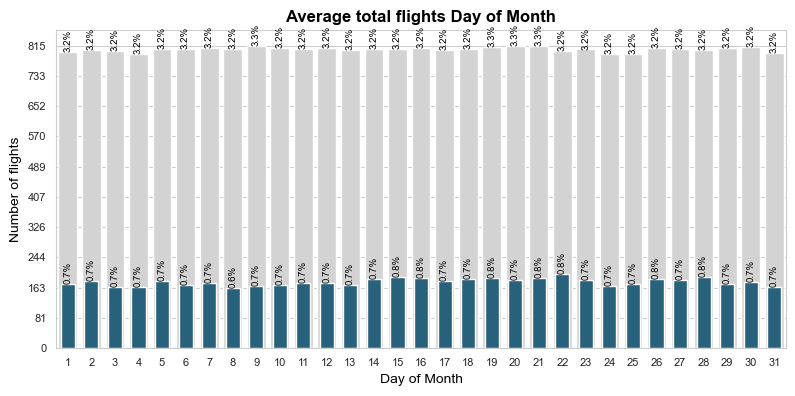

In [68]:
plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.day, annotate=False, title='Day of Month', rotate=True, sharey=False)
plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.day, annotate=True, title='Day of Month', rotate=True)

>There are no clear peaks during the month

#### Can we spot peaks in certain days of the week ? 

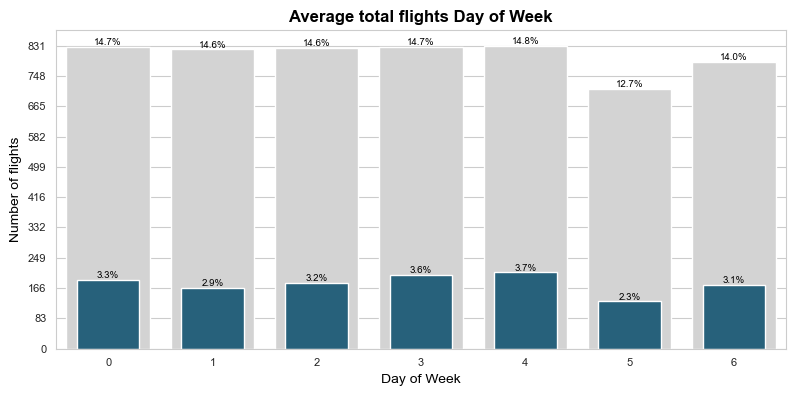

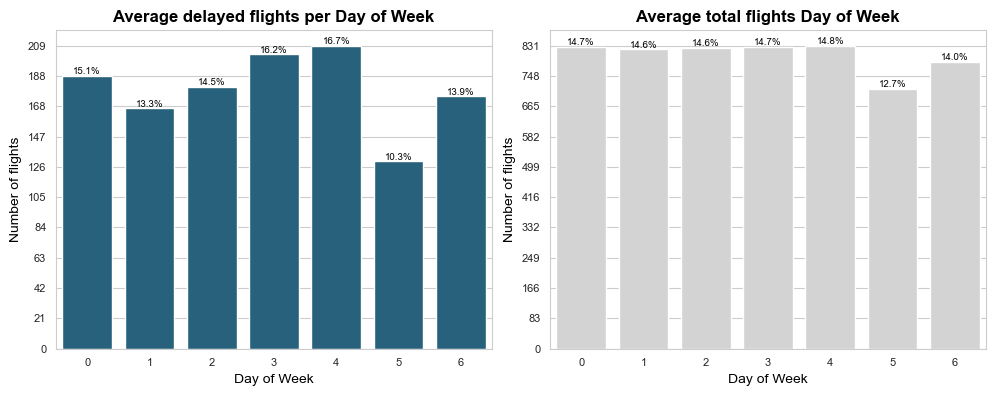

In [70]:
plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.dayofweek, annotate=True, title='Day of Week', rotate=False)
plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.dayofweek, annotate=True, title='Day of Week', rotate=False, sharey=False)

> Mondays, Wednesdays and Thursdays are the busiest days, where as Tuesdays and Saturdays are the most quiet. Weekends are more quiet than weekdays

#### Can we spot peaks in certain times of a day ? 

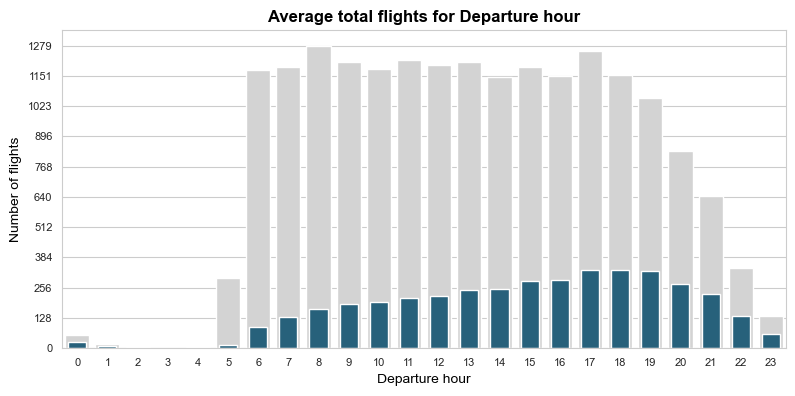

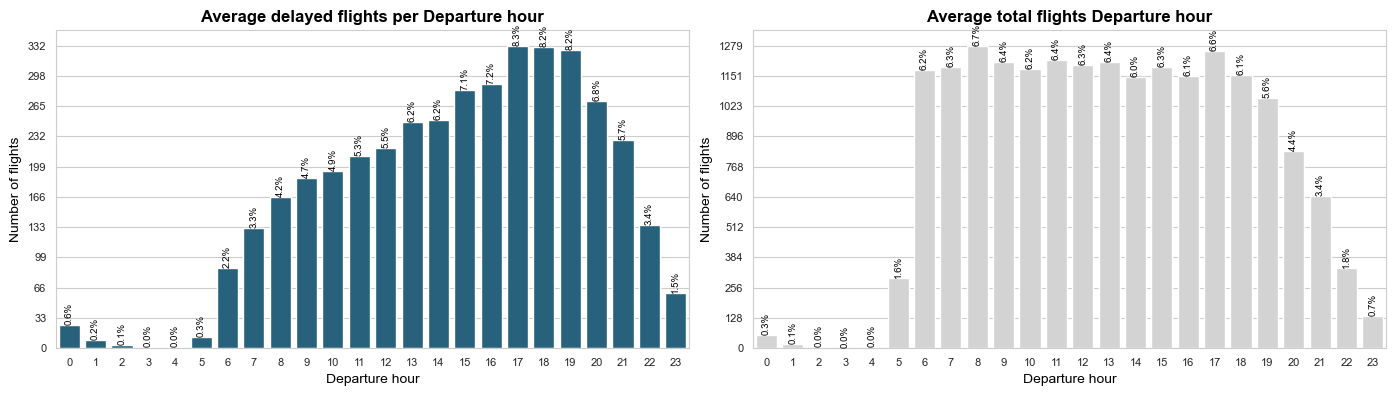

In [74]:
plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=False, title='Departure hour', rotate=False)
plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=True, title='Departure hour', rotate=True, sharey=False)

>Delays are growing progressively throughout the day starting at 6am until 8pm where as the total number of flights stay constant. Delay peaks are between for 5-8pm. 
From 8pm, both the delays and number of flights decrease.  

#### Can we confirm the seasonal patterns for summer and xmas periods in time series plotting?

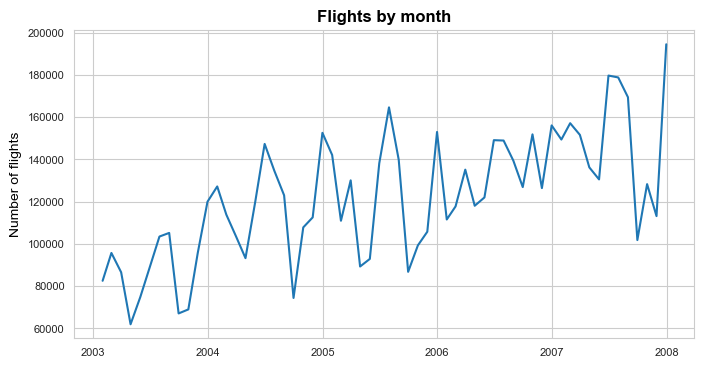

In [75]:
plt.errorbar(x=flight_timeseries_month.index, y=flight_timeseries_month['delayed'])
plt.title('Flights by month')
plt.ylabel('Number of flights')
plt.show()

We can visually observe an upwards trend in delayed flights per year, delayed flights are increasing

#### Compare average percentage change per month for all flights vs delays

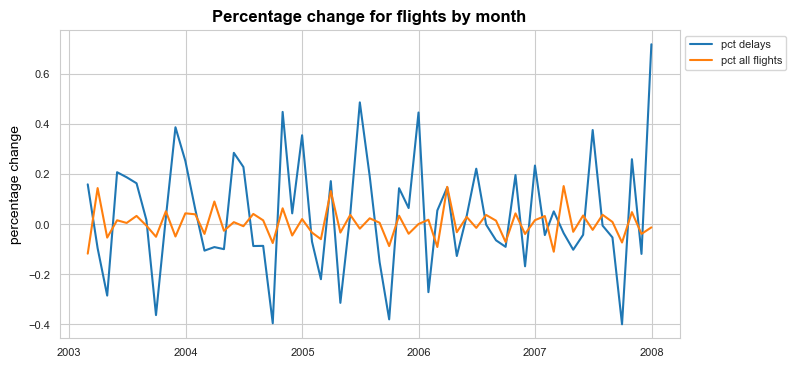

In [76]:
plt.errorbar(x=flight_timeseries_month.index, y=flight_timeseries_month['pct_delay'], label='pct delays')
plt.errorbar(x=flight_timeseries_month.index, y=flight_timeseries_month['pct_all'], label='pct all flights')
plt.title('Percentage change for flights by month')
plt.ylabel('percentage change')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show()

# TODO: try scaling techniques to nomarize these numbers for comparison

>Percentage difference per month for delays have a much larger range than percentage difference for all flights. This indicates that throughout the year, roughly the same number of flights fly between locations, whereas we experience more delays in airports during peak times. This suggest, that flights in peak times might be fully booked, attracting more passengers to the airports, and airports cannot cope with the volume of people, even if the number of planes stay the same.

#### Use statsmodels auto and partial correlation to pickup seasonal patterns

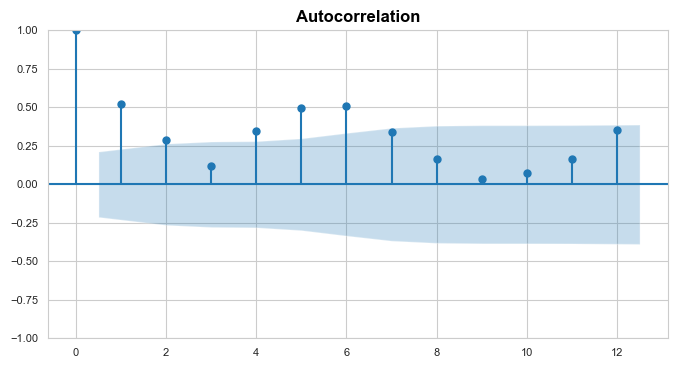

In [77]:
# plotting autocorrelations
fig = tsaplots.plot_acf(flight_timeseries_month['delayed'], lags=12, alpha=0.1)
plt.show()

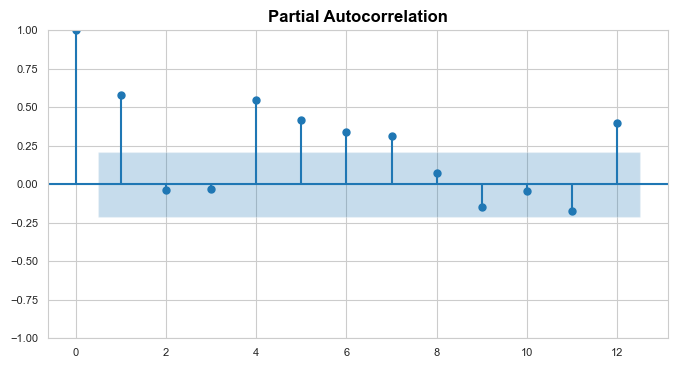

In [78]:
# plotting partial autocorrelations
fig = tsaplots.plot_pacf(flight_timeseries_month['delayed'], lags=12, alpha=0.1, method = "ols")
plt.show()

Looking at autocorrelations and partial correlations, we pickup a correlation at lag 1, which suggest there might be a pattern with a month ?
There is also a strong correlation at lag 4 which suggest a seasonal pattern for the summer peak, and another strong correlation at lag 12 xmas period

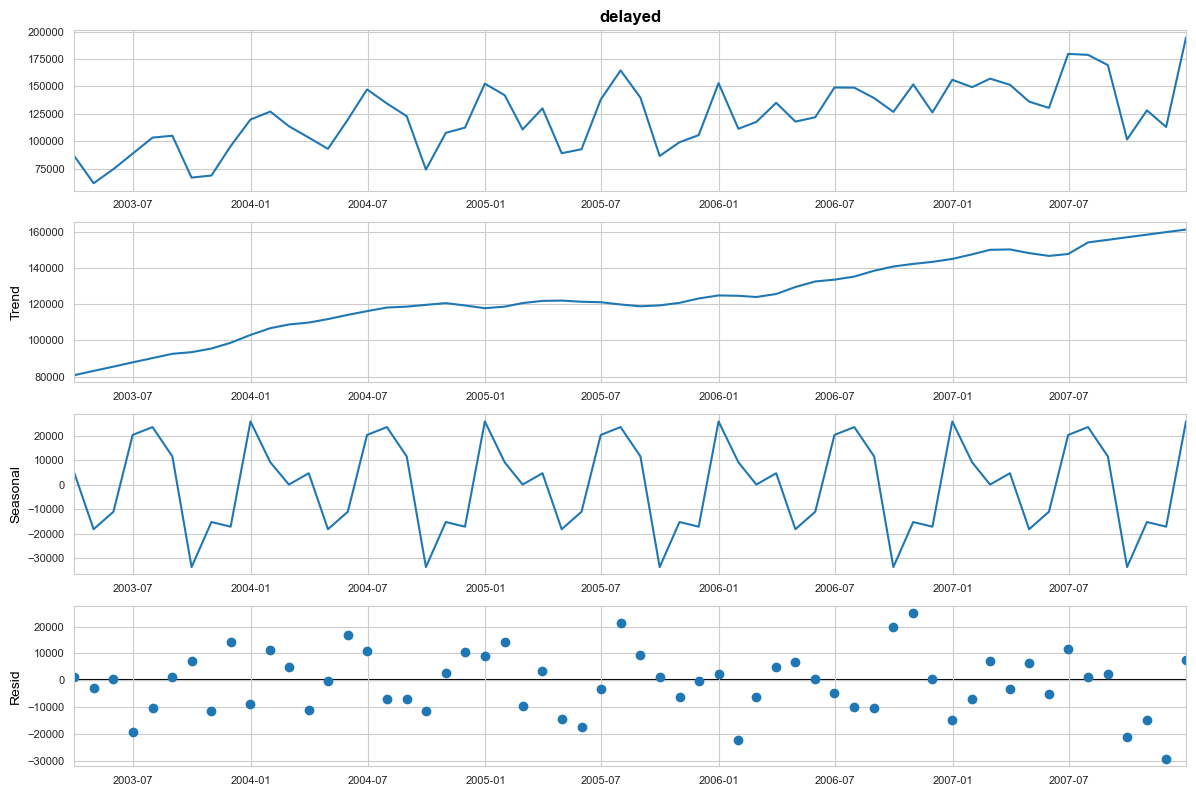

In [79]:
# print seasonal patterns using stats models
plt.rc("figure", figsize=(12,8))
flight_timeseries_month.dropna(inplace=True)
decomposition = sm.tsa.seasonal_decompose(flight_timeseries_month['delayed'], extrapolate_trend='freq')
decomposition.plot()
plt.show()

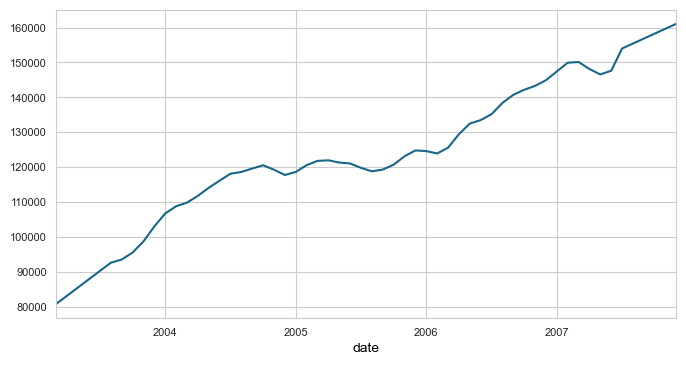

In [80]:
plt.rc("figure", figsize=(8,4))
trend = decomposition.trend
ax = trend.plot(color=BASE_COLOR)

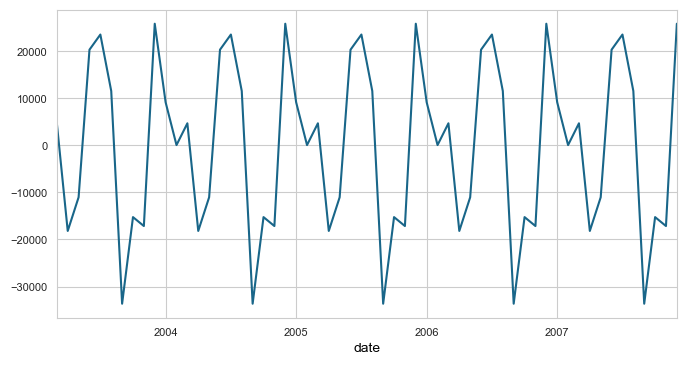

In [81]:
season = decomposition.seasonal
ax = season.plot(color=BASE_COLOR)

Using statmodels we can confirm a strong seasonal pattern during summer and christmas periods. We also see a upward trent where delays increase every year, at a higher rate that flights.

### **Delay summary:**

>When flights increase, delays increase as well, although delays grow at a higher rate.
There is definite upwards trend in flights and delays year apon year
There is a strong seasonal pattern. There are 2 strong peaks, the biggest one around xmas time in December - March, and another one during summer months June - August.
Mondays, Wednesdays and Thursdays are the busiest times at airports, it is the most quiet on Tuesdays and Saturdays.
Delays grows progressively throughout the day, with most delays happening between 19:00-22:00

### Categorical analysis

In [82]:
total_delayed_flights = flight_delays.shape[0]
print('Total delayed flights: {}'.format(total_delayed_flights))

Total delayed flights: 7306662


In [83]:
def delays_by_cat(df, col, title='Origin airports', topn=20):
  
    # calculate top category and order of bar charts
    top = df[col].value_counts(ascending=False)
    top_order = top.index[:topn]     


    clrs = [BASE_COLOR if i >= 3 else BASE_HIGHLIGHT for i in np.arange(0,topn+1,1)]
              
    ax = sns.countplot(data=df, y=col, order=top_order, palette=clrs, orient='h', width=0.6)
       
    plt.title('{} with the most delayed flights'.format(title), weight='bold')
    plt.xlabel(title)
    plt.ylabel('Number of delayed flights')

    # improve xticks and labels      
    ticks, xlabels, binsize = improve_yticks(top[0]) 
    plt.xticks(ticks, xlabels) 
    
#   calculate and print % on the top of each bar
    ticks = ax.get_yticks()
    new_labels = []
#     gap = top[0]*0.05
    locs, labels = plt.yticks()
    for loc, label in zip(locs,labels):
        count = top[loc]
        perc = '{:0.1f}%'.format((count/top.sum())*100)
        # print only the first characters of xlabel descriptions
        text = top.index[loc][:20]
        new_labels.append(text)
        plt.text(count+(0.2*binsize), loc, perc, ha='center', va='center', color='black', fontsize=6, weight='ultralight')
    plt.yticks(ticks, new_labels, fontsize=8, weight='ultralight')
    
    plt.tight_layout()
    plt.show()

In [134]:
def plot_categories(df, annotate=True, title='month', rotate=False, topn=20, figsize=(10,6), orient='v'):
    
    ontime_total = df['on_time'].sum()
    delay_total = df['delayed'].sum()
    grand_total = ontime_total + delay_total
    
    df = df[:topn]
    # avoid do print too small numbers
    df = df.loc[df['delayed'] >= 10000]
    
    plt.figure(figsize=figsize)
    weight='ultralight'
    color='black'
    xytext = (0, 3)
    size=8   
    
    # Customize annotation
    if rotate:      
        rotation=90
        xytext = (0, 2)
    else:
        rotation=None
        xytext = (0, 3)    

    if orient == 'v':
        ax1 = sns.barplot(data=df, y=df.index, x='on_time', color=BASE_GREY, label='Ontime flights', errorbar=None, errwidth=1)
        ax2 = sns.barplot(data=df, y=df.index, x='delayed', color=BASE_COLOR, label='Delayed flights', errorbar=None, errwidth=1, width=0.6, edgecolor=BASE_COLOR) 
        ticks = ax1.get_yticks()
        locs, labels = plt.yticks()
    else:
        ax1 = sns.barplot(data=df, x=df.index, y='on_time', color=BASE_GREY, label='Ontime flights', errorbar=None, errwidth=1)
        ax2 = sns.barplot(data=df, x=df.index, y='delayed', color=BASE_COLOR, label='Delayed flights', errorbar=None, errwidth=1, width=0.6, edgecolor=BASE_COLOR)
        ticks = ax1.get_xticks()
        locs, labels = plt.xticks()
        
#   improve yticks
    maxvalue = df['on_time'].max()
    yticks, ylabels, binsize = improve_yticks(maxvalue)   
         
#   print only the first 20 characters of the categorical variable description
    new_labels = []
    for loc, label in zip(locs,labels):
        text = df.index[loc][:20]
        new_labels.append(text)
#         delay_count = df.iloc[loc]['delayed']
#         ontime_count = df.iloc[loc]['on_time']
#         delay_perc = '{:0.1f}%'.format(delay_count/delay_total*100)
#         ontime_perc = '{:0.1f}%'.format(ontime_count/ontime_total*100) 
#         if orient == 'v':
#             plt.text(delay_count-0.1*binsize, loc, delay_perc, ha='center', va='center', color='white', fontsize=6, weight='bold')
#             plt.text(ontime_count+0.1*binsize, loc, ontime_perc, ha='center', va='center', color='black', fontsize=6, weight='ultralight') 
#         else:
#             plt.text(loc, delay_count-0.1*binsize, delay_perc, ha='center', va='center', color='white', fontsize=6, weight='bold')
#             plt.text(loc, ontime_count+0.1*binsize, ontime_perc, ha='center', va='center', color='black', fontsize=6, weight='ultralight') 
    
    if orient == 'v':
        plt.yticks(ticks, new_labels, fontsize=8, weight='ultralight')
        plt.ylabel(title)
        plt.xlabel('Number of flights')
        plt.xticks(yticks, ylabels) 
    else:
        plt.xticks(ticks, new_labels, rotation=90, fontsize=8, weight='ultralight') 
        plt.ylabel(title)
        plt.xlabel('Number of flights')
        plt.yticks(yticks, ylabels)  
        
        
    # annote bars with % proportion, doing this way gives flexibility we an print proportion of one bar another
    grand = []
    
    # print text outside the bar, determine gap between bar and text dynamically based on binsize
    if binsize >= 500000:
        gap = 0.5*binsize
    if binsize >= 200000:
        gap = 0.15*binsize            
    else:
        gap = 0.15*binsize   
        
    for i, p in enumerate(ax2.patches):
        prop = None
        # there are 2 bars for each feature. those with index 0-19 are the onetime bards, and 20-39 are the delay bars   
        if i >= len(df):
            # this is for smaller delay bars
            index = i - len(df)

            # print text inside the bar
            gap = -abs(gap)
          
            color='white'
            weight='bold'
            size=6

            if orient == 'v':
                xytext=(0,6)
                val = p.get_width()/grand_total
            else:
                xytext=(0,-8)
                val = p.get_height()/grand_total
                
            # calculate proportion of delay / on_time
            val = val/grand[index] 
        else:
            # logic for the biggest bar, in this case ontime
            index = i
            
            gap = abs(gap)
            color='black'
            weight='ultralight'
            size=6
            
            if orient == 'v':
                val = p.get_width()/grand_total
#                 space = len(str(val))+3
                xytext=(0,6)
            elif rotate:
                xytext=(0,8)
                val = p.get_height()/grand_total
            else: 
                xytext=(0,3)
                val = p.get_height()/grand_total
                
#           save proportion of ontime bar to reuse for proportation cals in delay barsd              
            grand.append(val)
            
        if orient == 'v':
            ax2.annotate("{:.2%}".format(val),     
                                        (p.get_x() + p.get_width() + gap, p.get_y() + 0.6),
                                         ha = 'center', va = 'center', 
                                         xytext = xytext,
                                         textcoords = 'offset points',
                                         size=size, 
                                         weight=weight,
                                         rotation=rotation,
                                         color=color) 
           
        else:
            ax2.annotate("{:.2%}".format(val), 
                                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                                         ha = 'center', va = 'center', 
                                         xytext = xytext,
                                         textcoords = 'offset points',
                                         size=size, 
                                         weight=weight,
                                         rotation=rotation,
                                         color=color)             
        
    plt.title('DELAYED vs ON-TIME flights by {}'.format(title))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='flight_status')
    plt.tight_layout()
    plt.show()

#### Which airports cause the most delays ?

Compare the flight distribution in departure and arrival aiports and their cities

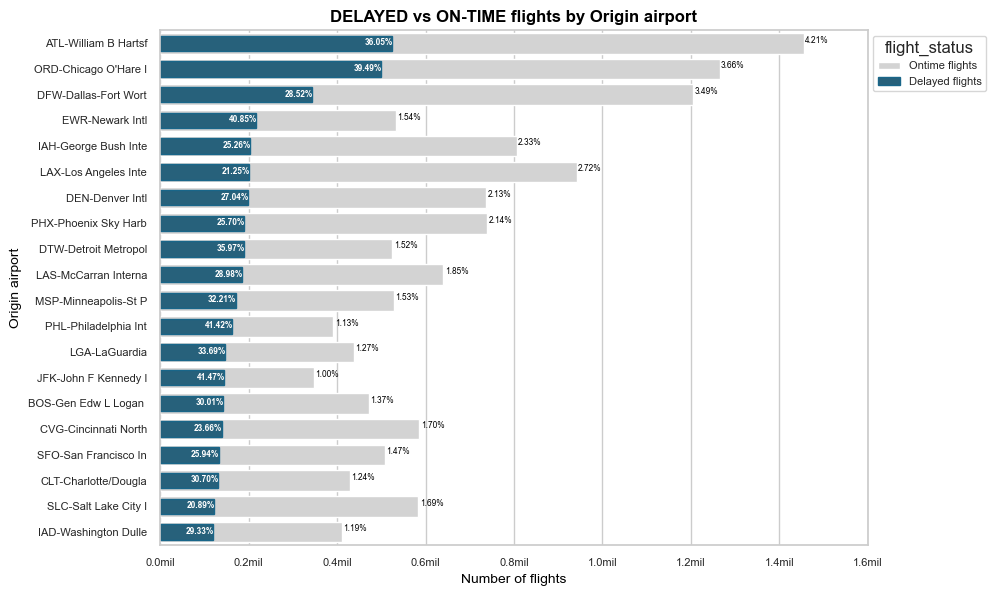

In [533]:
delays_by_cat(df=flight_delays, col='origin', title='Origin airport')
origin = flights.groupby('origin')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
origin['airport'] = origin.index + '-' + airports.loc[origin.index]['airport']
origin.reset_index(inplace=True)
origin.set_index('airport', inplace=True)
plot_categories(df=origin, title='Origin airport')

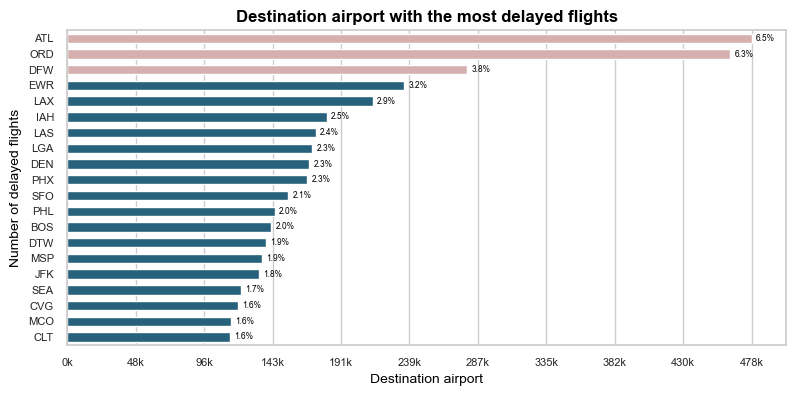

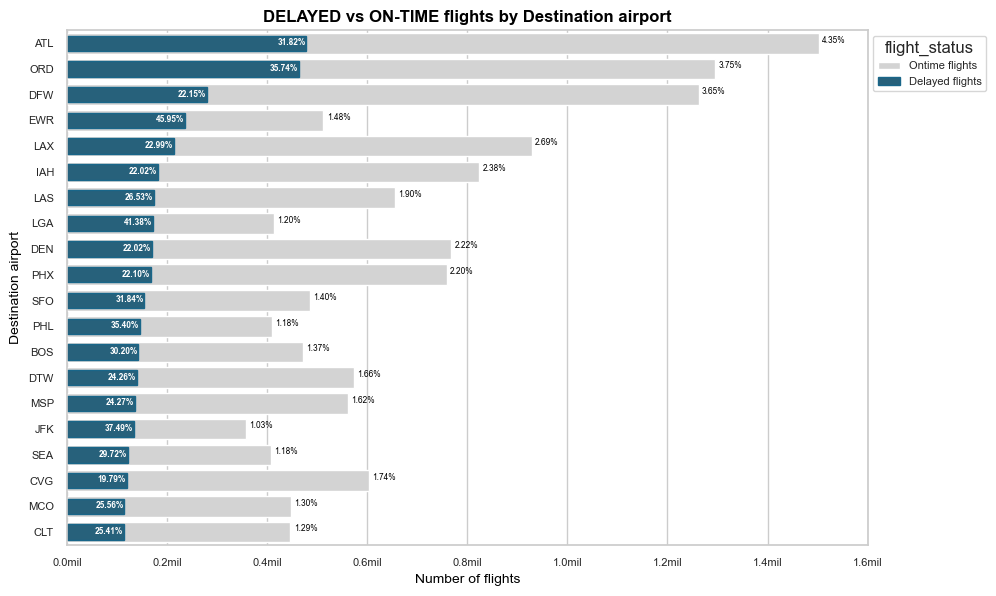

In [536]:
delays_by_cat(df=flight_delays, col='dest', title='Destination airport')
dest = flights.groupby('dest')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
# dest['airport'] = dest.index + '-' + airports.loc[dest.index]['airport']
# dest.reset_index(inplace=True)
# dest.set_index('airport', inplace=True)
plot_categories(df=dest, title='Destination airport')

>The top origin airports (ATL, ORD, DFW) are also the top destination airports causing delays, meaning a delay in the origin is causing a delay in the destination.
>From a proportional perspective, EWR, PHL and JFK are watchouts with over 41% of their flights delayed

#### Which lanes cause the most delays ?

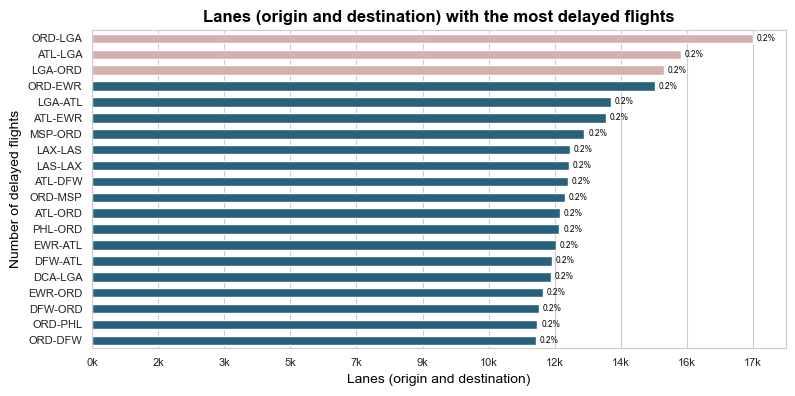

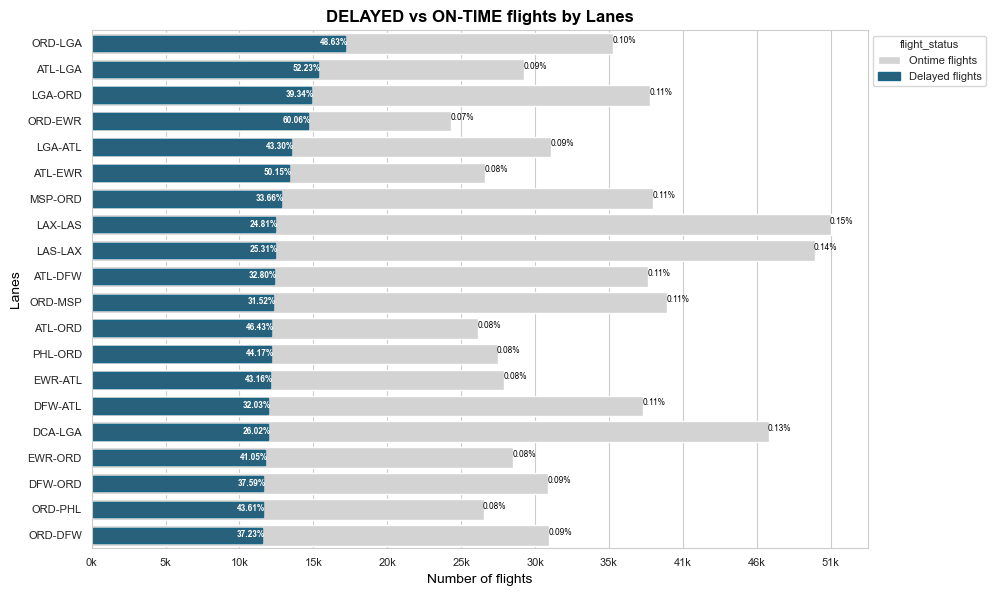

In [138]:
delays_by_cat(df=flight_delays, col='lane', title='Lanes (origin and destination)')
lanes = flights.groupby('lane')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
plot_categories(df=lanes, title='Lanes')

>When looking at lane level, the delays seems to be fairly equally distributed, although the top lanes have always one of the top 3 delay airport as either origin or destination
>From a proportional perspective, ORD-EWR are a concern with 60% of it's flights delayed. Also ATL-ORD deserves a shoutout at 46%

>When a lane consist of a combination where both  origin and destination airports are ORD, EWR, ATL, DFW its a definete stay away or take a nice book !

#### Which cities cause the most delays ?

In [139]:
# aggration rule for all category plots
f = {'delayed':'sum', 'on_time':'sum'}

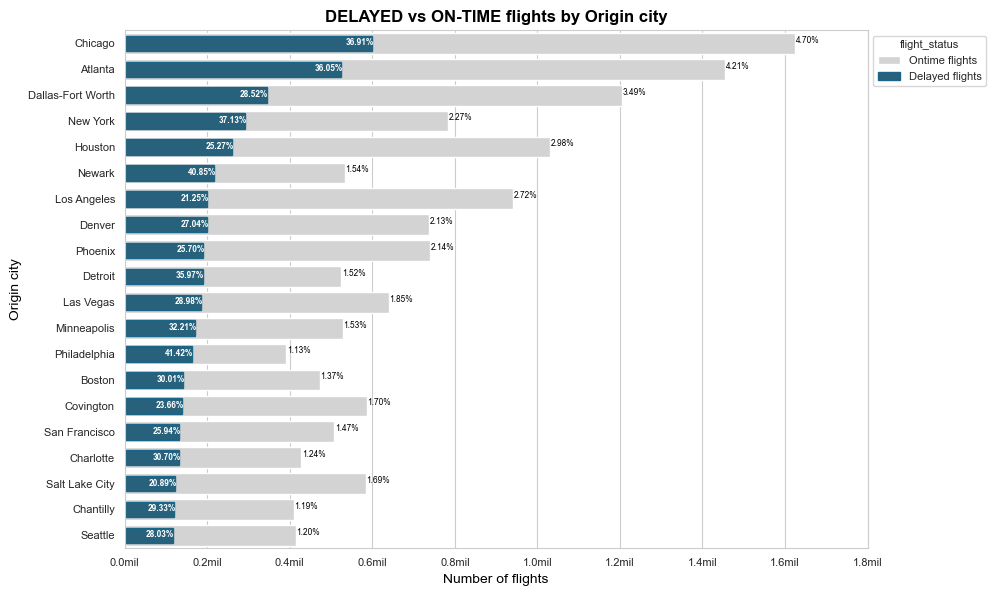

In [140]:
origin_enhanced = origin.reset_index()
origin_enhanced = origin.merge(airports, how='inner', right_on='iata', left_on='origin')
origin_city = origin_enhanced.groupby(['city']).agg(f)
origin_city.sort_values(by='delayed', ascending=False, inplace=True)
plot_categories(df=origin_city, title='Origin city')

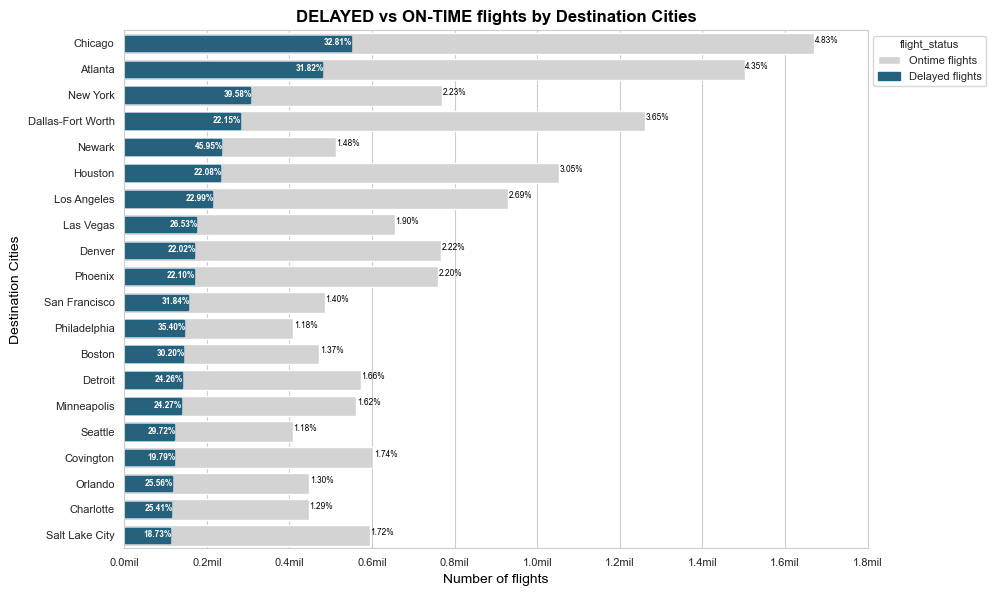

In [141]:
dest_enhanced = dest.reset_index().copy()
dest_enhanced = dest.merge(airports, how='inner', right_on='iata', left_on='dest')
dest_city = dest_enhanced.groupby(['city']).agg(f)
dest_city.sort_values(by='delayed', ascending=False, inplace=True)
plot_categories(df=dest_city, title='Destination Cities')

>The top origin airports (ATL, ORD, DFW) are also the top destination airports causing delays, meaning a delay in the origin is causing a delay in the destination.
Cities Atlanta, Chicago, Dallas and New York have the most delays

#### Which carriers cause the most delays ?

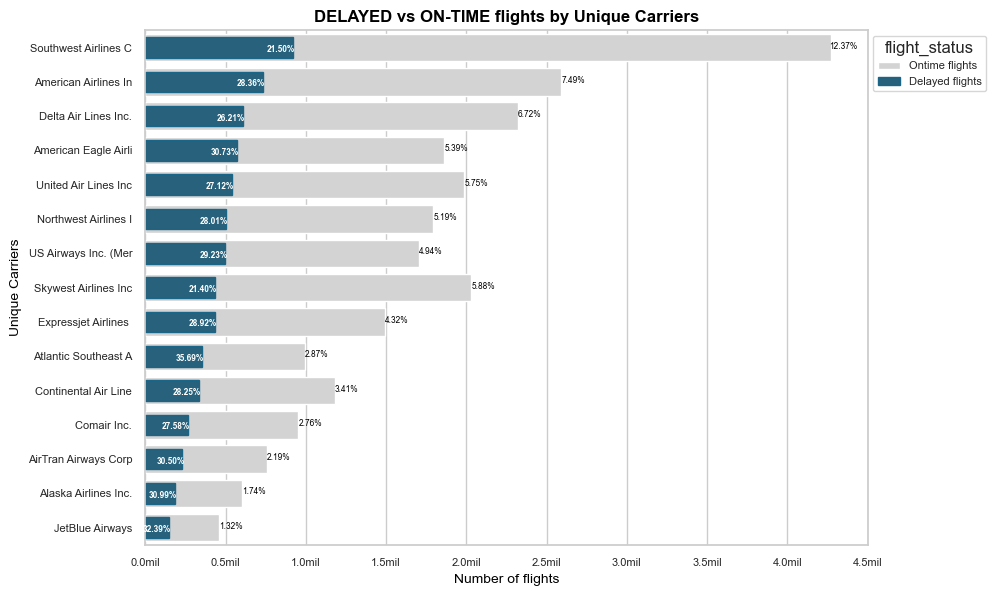

In [237]:
cat_carrier = flights.groupby('uniqueCarrier')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
cat_carrier = cat_carrier.merge(carriers, how='inner', on='uniqueCarrier')
cat_carrier.set_index('carrier_description', inplace=True)
plot_categories(df=cat_carrier, title='Unique Carriers', topn=15)

Southwest Airlines operate 12.4% of all flights, and their delays are the biggest at 2.7%. From a proportational flights vs delays point of view, Americal Airlines and Delta Air Lines have are of bigger concern.

#### Which plane characteristics causes the most delays ?

Plot plane chacteristics causing delays vs those planes that are on-time

In [143]:
# get plane characteristics
plane_data = flights.groupby('tailNum')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)

plane_data = plane_data.merge(planes, how='inner', right_on='tailnum', left_on='tailNum')

plane_data['year'] = plane_data['year'].replace('None', None)
plane_data['year_issue'] = plane_data['issue_date'].replace('None', None)

plane_data['date1'] = pd.to_datetime(plane_data['year_issue'], errors='coerce', format='%Y/%m/%d')
plane_data['date2'] = pd.to_datetime(plane_data['year_issue'], errors='coerce', format='%m/%d/%Y')
plane_data['year_issue'] = plane_data['date1'].fillna(plane_data['date2'])
plane_data.dropna(axis=0, inplace=True, subset=['year_issue', 'year'])

plane_data['year_issue'] = plane_data['year_issue'].dt.year
plane_data['year_issue'] = plane_data['year_issue'].astype(int)
plane_data['year'] = plane_data['year'].astype(int)

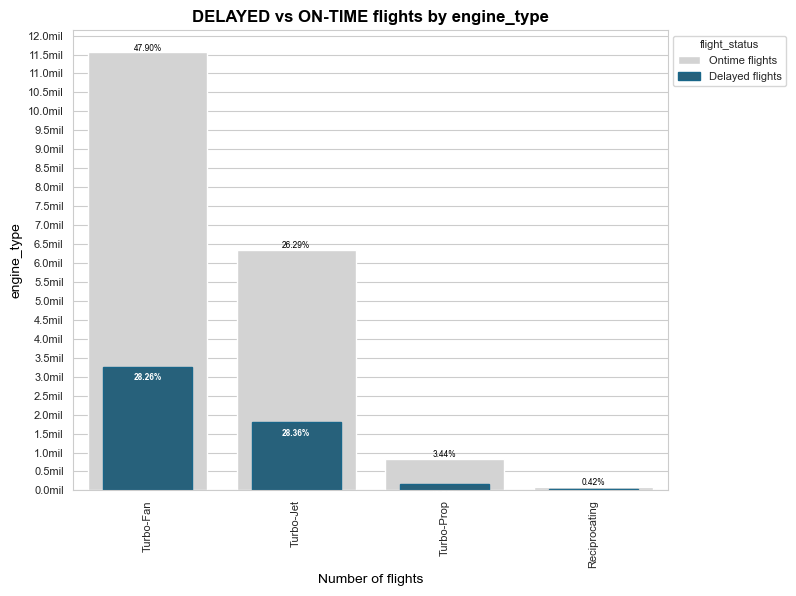

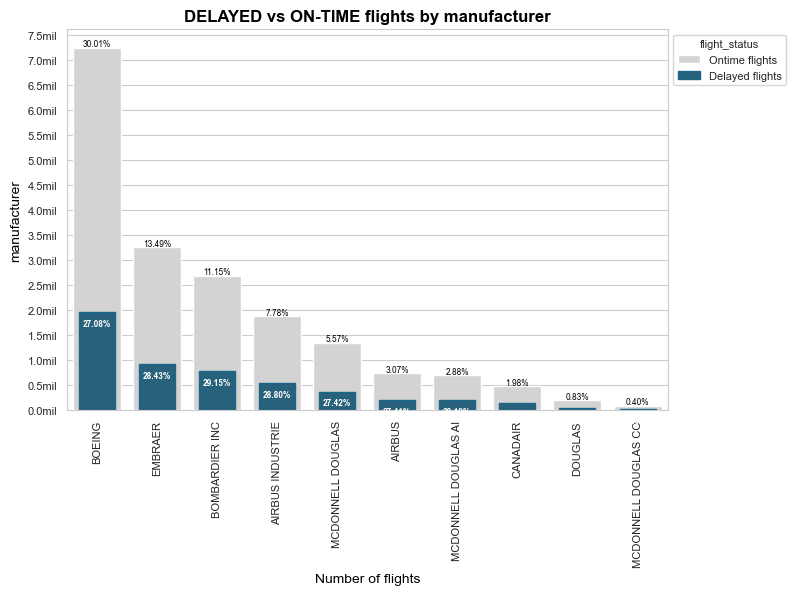

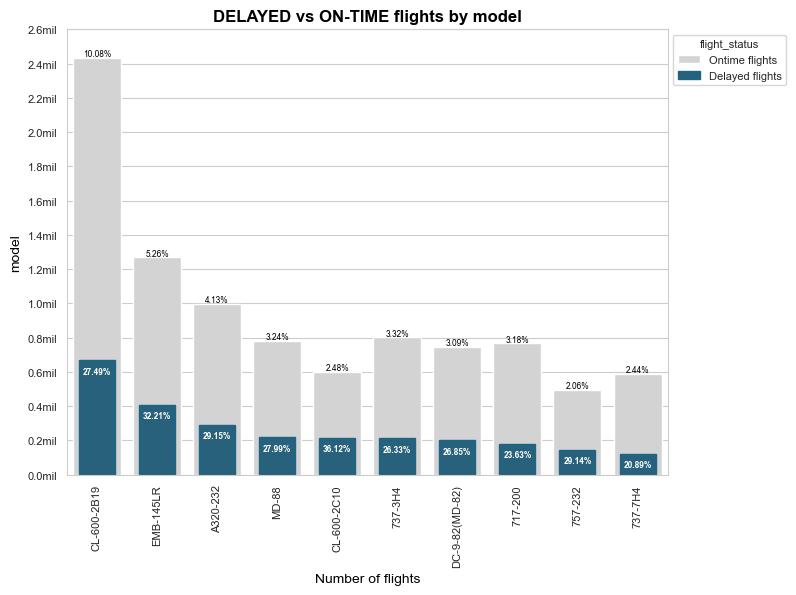

In [144]:
col = ['manufacturer', 'engine_type', 'model']
col.sort()

for c in col:
    df = plane_data.groupby(c).agg(f).sort_values(by='delayed', ascending=False)
    df.index = df.index.astype(str)
    plot_categories(df=df, title=c, topn=10, orient='h',figsize=(8,6))    

When comparing categorical features using proportion of delays over on-time flights, characteristics are quite similar with a factor of around 30%. 
Only watch-out would be airplane model CL-600-2C1D which have a factor of 37%

#### Is it the oldest planes that cause delays ?

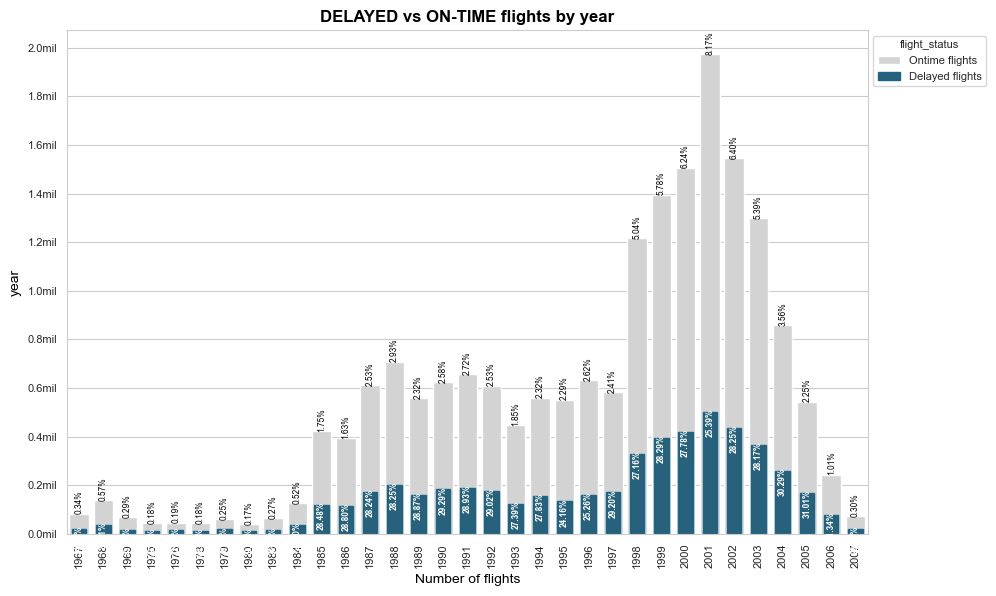

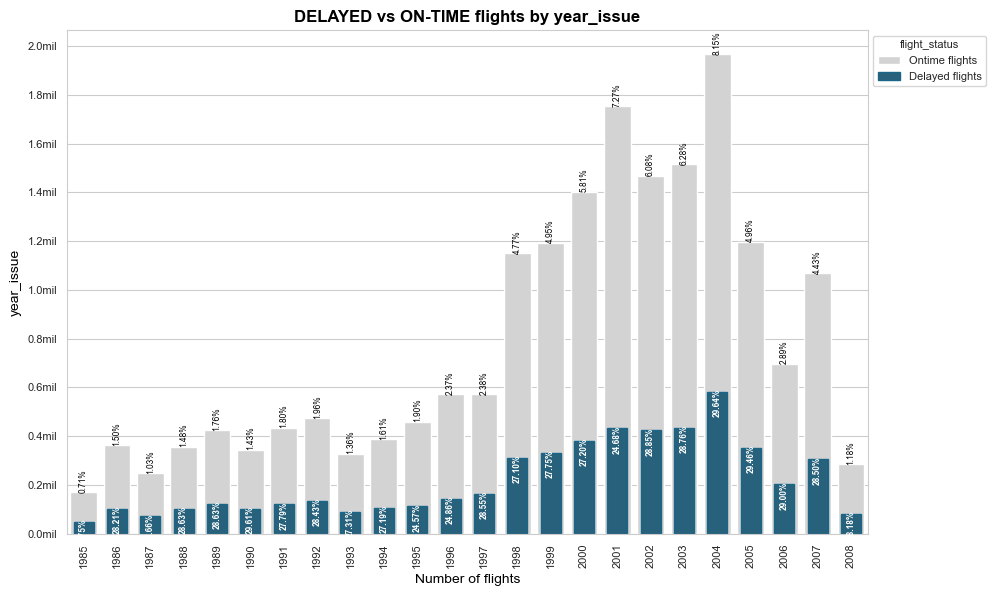

In [145]:
col = ['year', 'year_issue']
col.sort()

for c in col:
    df = plane_data.groupby(c).agg(f)
    df.index = df.index.astype(str)
    plot_categories(df=df, title=c, topn=100, orient='h', rotate=True, figsize=(10,6))    

Ironically, delays occur in more younger planes. Planes from year 2004 seem to cause the most delays which is quite surprising.

In [ ]:
col = ['manufacturer', 'year_y', 'engine_type', 'model', 'year_issue']
col.sort()

grand_total = len(flights_enhanced)

for c in col:
    
    fig, ax = plt.subplots(ncols=2, figsize=(16,4))    
    
    # get top biggest delays for each column
    top_delay = delays_enhanced[c].value_counts()
    top_delay = top_delay.loc[top_delay > 50000]
    top_order = top_delay.index[:10]
    # to calculate bar % later
    top_ontime = ontime_enhanced[c].value_counts()

    plt.subplot(1,2,1)
    ax = sns.countplot(x=c, data=flights_enhanced, hue='flight_status', order=top_order, palette={'delayed': BASE_COLOR, 'on_time': BASE_GREY}, dodge=True, width=0.7)
    ax.set_title('Delay vs on-time flights proportion of all flights'.format(c))
    
    
    # print % on top of bars
    delay = []
    grand = []
    for i, p in enumerate(ax.patches):
        prop = None
        # there are 2 bars for each feature   
        if i >= len(top_order):
            index = i - len(top_order)
            val = p.get_height()/grand_total
            # calculate proportion of delay / on_time
            prop = val/grand[index]
            delay.append(prop)            
        else:
            index = i
            val = p.get_height()/grand_total
            grand.append(val)
            
        ax.annotate("{:.0%}".format(val), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 2), 
                   textcoords = 'offset points',
                   size=8, 
                   weight='ultralight')

            
    # format yticks        
    yticks = ax.get_yticks()
    ylabels = ['{:1.0f}'.format(tick) for tick in yticks]
    plt.yticks(yticks, ylabels)   
    plt.ylabel('Number of flights')
    
    # PLOT 2 - proportions
    plt.subplot(1,2,2)
#     clrs = [BASE_COLOR if i < max(delay) else BASE_HIGHLIGHT for i in delay]
    ax2 = sns.barplot(x=top_order, y=delay, color=BASE_COLOR, width=0.5)
    ax2.set_title('Proportion delay/on_time'.format(c))
    ax2.set_ylabel('Proportion delay % / on_time %')
    
    
    # improve xticks to be max 15 characters long
    tickslabels = ax.get_xticklabels()
    new_tickslabels = []
    locs, labels = plt.xticks()
    for loc, label in zip(locs,labels):
        text = label.get_text()
        new_tickslabels.append(text[:15])
    ax.set_xticklabels(new_tickslabels, rotation=90)    
    ax2.set_xticklabels(new_tickslabels, rotation=90)    
    
    # annotate bars with proporation value
    for p in ax2.patches:
        val = p.get_height()
        ax2.annotate("{:.2f}".format(val), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 2), 
                   textcoords = 'offset points',
                   size=8, 
                   weight='ultralight')
    
    plt.xlabel(c)
    plt.suptitle('Column "{}"'.format(c), color=BASE_COLOR)
    plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

<blockquote>


**Most signifant findings:**

- Around 76% of flights are on-time, where as 21% are delayed. Only 2% of flights are cancelled or diverted which is therefore not the main concern

- Both departure and arrival delays in minutes are right skewed. When plotted on a log scale, arrival delays are still right skewed whilst departure delays are more normally distributed. Arrival delays were restricted to >= 15 minutes, which was not the case for departure delays, otherwise departure delays would also be right skewed.

- Most arrivals are on average 20 minutes late. There is a steep decline in delays > 20 minutes.

- The top 3 reasons for delays are caused by late aircrafts, NAS (Air traffic control), and carriers:
    - 36% of delays are caused by late aircrafts with an average of 19 minutes delay
    - 31% of delays are caused by NAS with an average of 16 minutes delay 
    - 28% of delays are caused by carriers with an average of 15 minutes delay
    - Weather and security cause only 6% of all delays

- Late aircraft, NAS and carrier delays are all right skewed, with a normal distribution on log scale. The mean delay on log scale are around 20-25 min

- When flights increase, delays increase as well, although delays grow at a higher rate. There is definite upwards trend in flights and delays year apon year. 

- There is a strong seasonal pattern. There are 2 strong peaks, the biggest one around christmas time in December - March, and another one during summer months June - August. Delays decrease in spring/autumn months

- Most delays happens on weekdays on Monday, Wednesday and Thursday when there are more slightly more flights than on other days. Airports are less busy with less delays on weekends. Tuesdays and Saturdays are the quietest days
    
- Delays are growing progressively throughout the day starting at 6am until 8pm where as the total number of flights stay constant. Delay peaks are between for 5-8pm. 
From 8pm, both the delays and number of flights decrease.  

- Percentage difference per month for delays have a much larger range than percentage difference for all flights. This indicates that throughout the year, roughly the same number of flights fly between locations, whereas we experience more delays in airports during peak times. 

- The top 3 airports causing the most delays, are in larger cities of Atlanta, New York and Chicago.

- The top origin airports (ATL, ORD, DFW) are also the top destination airports causing delays, meaning a delay in the origin is causing a delay in the destination.
  - From a proportional perspective, EWR, PHL and JFK are watchouts with over 41% of their flights delayed

- Southwest Airlines operate 12.4% of all flights, and their delays are the biggest at 2.7%. From a proportational flights vs delays point of view, Americal Airlines and Delta Air Lines have are of bigger concern.

- Ironically, most delays occur in younger planes which also flies more frequently. 

- When looking at lane level, the delays seems to be fairly equally distributed, although the top lanes have always one of the big cities as origin or destination

- When comparing categorical plane features using proportion of delays over on-time flights, characteristics are quite similar with a factor of around 30%. Delays seem to be evenly distributed and are not caused by certain planes. Only watch-out would be airplane model CL-600-2C1D which have a factor of 37%

**Conclusion:**

There is not as much variation in the average total flights per month **even in the peak periods**, which suggest it's not the number of flights itself that are causing the problem. The delays happens in the peak seasons in large cities mostly during the week, which suggest the biggest driver for delays might be due to passenger throughput?
There's a watch out on certain airports and cities, which could be seasonal consequence.

</blockquote>
    
    
### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

<blockquote>
    
- 2008 does not contain data for the full year, only Jan - April is available. This year was excluded from futher analysis
- Planes from year 2004 seem to cause the most delays which is quite surprising.
- I introduced new features like:
    - flight status to make analytical comparisons of cancelled, diverted, delayed and ontime flights easier
    - a date field, to make time series analyses possible to pick-up seasonal trends

</blockquote>

We continue our investigation focussing on delayed flights only

## Bivariate Exploration

<blockquote>
Around 21% of flights are delayed, whereas only 2% of flights are cancelled or diverted which is not therefore not the main concern. Let's continue our investigation, focusing on delays only.

Using the dataset that contains *delays* only, investigate the relationships between:
- Departure and arrival delays, having a deeper look at their relationship
- Numerical variables
- A deeper look at top carriers, cities/airports, and their relationships with each other example are the top carriers operating only in big cities ? Does these carriers cause problems overall, or are they a victim of an already busy airport ?
</blockquote>

In [146]:
# clear the garbage to free memory
gc.collect()

31378

In [147]:
numeric_vars = ['arrDelay', 'depDelay', 'airTime', 'distance', 'taxiIn', 'taxiOut', 'carrierDelay', 'NASDelay', 'lateAircraftDelay']

In [148]:
# take a sample of delays to speed up performance
sample = np.random.choice(flight_delays.shape[0], 50000, replace=False)
flight_delays_sample = flight_delays.iloc[sample].copy()

# handle logscale
for col in numeric_vars:
    flight_delays_sample[col] = np.where(flight_delays_sample[col] == 0, 0.9, flight_delays_sample[col])
    
flight_delays_sample.shape

(50000, 29)

In [149]:
# take a sample of all flights to speed up performance
sample = np.random.choice(flights.shape[0], 50000, replace=False)
flight_sample = flights.iloc[sample].copy()

# handle logscale
for col in numeric_vars:
    flight_sample[col] = np.where(flight_sample[col] == 0, 0.9, flight_sample[col])
    
flight_sample.shape

(50000, 29)

#### Lets get a quick overview of relationships between numerical values of interest

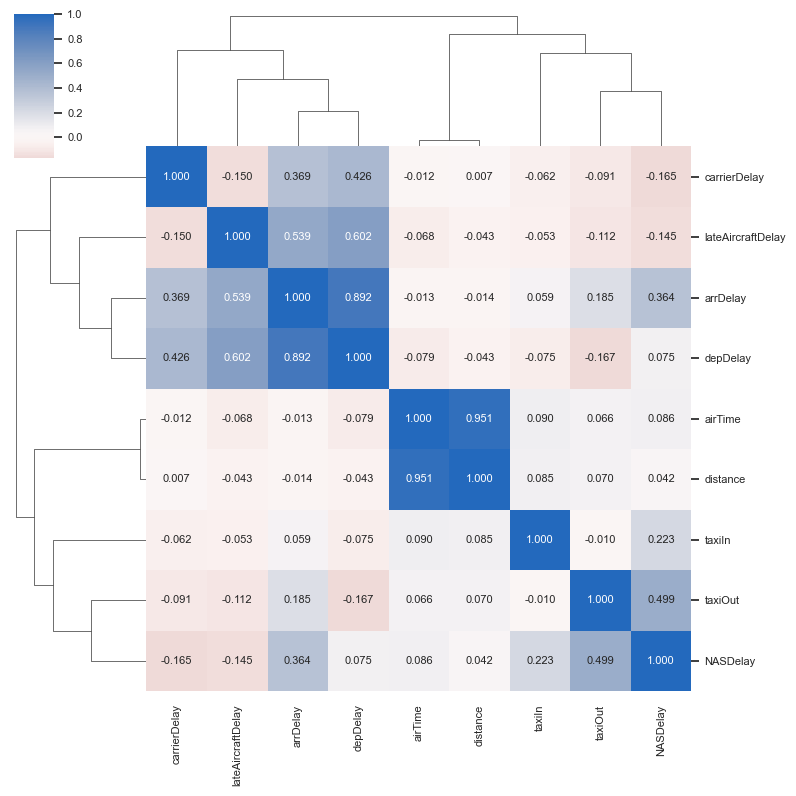

In [597]:
# correlation plot for numeric values of interest

# plt.figure(figsize = [8, 5])
# sns.heatmap(flight_delays_sample[numeric_vars].corr(), annot = True, fmt = '.3f',
#            cmap = 'vlag_r', center = 0)

sns.clustermap(flight_delays_sample[numeric_vars].corr(), cmap="vlag_r", center=0, annot=True, fmt = '.3f', figsize=(8,8))
plt.show()

**Observations from heatplot:**
- arrDelay and depDelay have strong positive correlation, which we already discovered during univariate exploration
- depDelay have a stronger correlation with carrierDelay and lateAircraftDelay, than arrDelay. NAS does not seem be the main reason for delay in departures
- arrDelay have a stronger correlation with NASDelay than depDelay. NAS seems to be main reason for delays in destinations
- airTime and Distance have a strong positive correlation, which make sense. The longer the flight, the longer we will be in the air.
- taxiIn and taxiOut have a positive correlation with NASDelays, which could indicate air control is causing the taxiIn and taxiOut delays

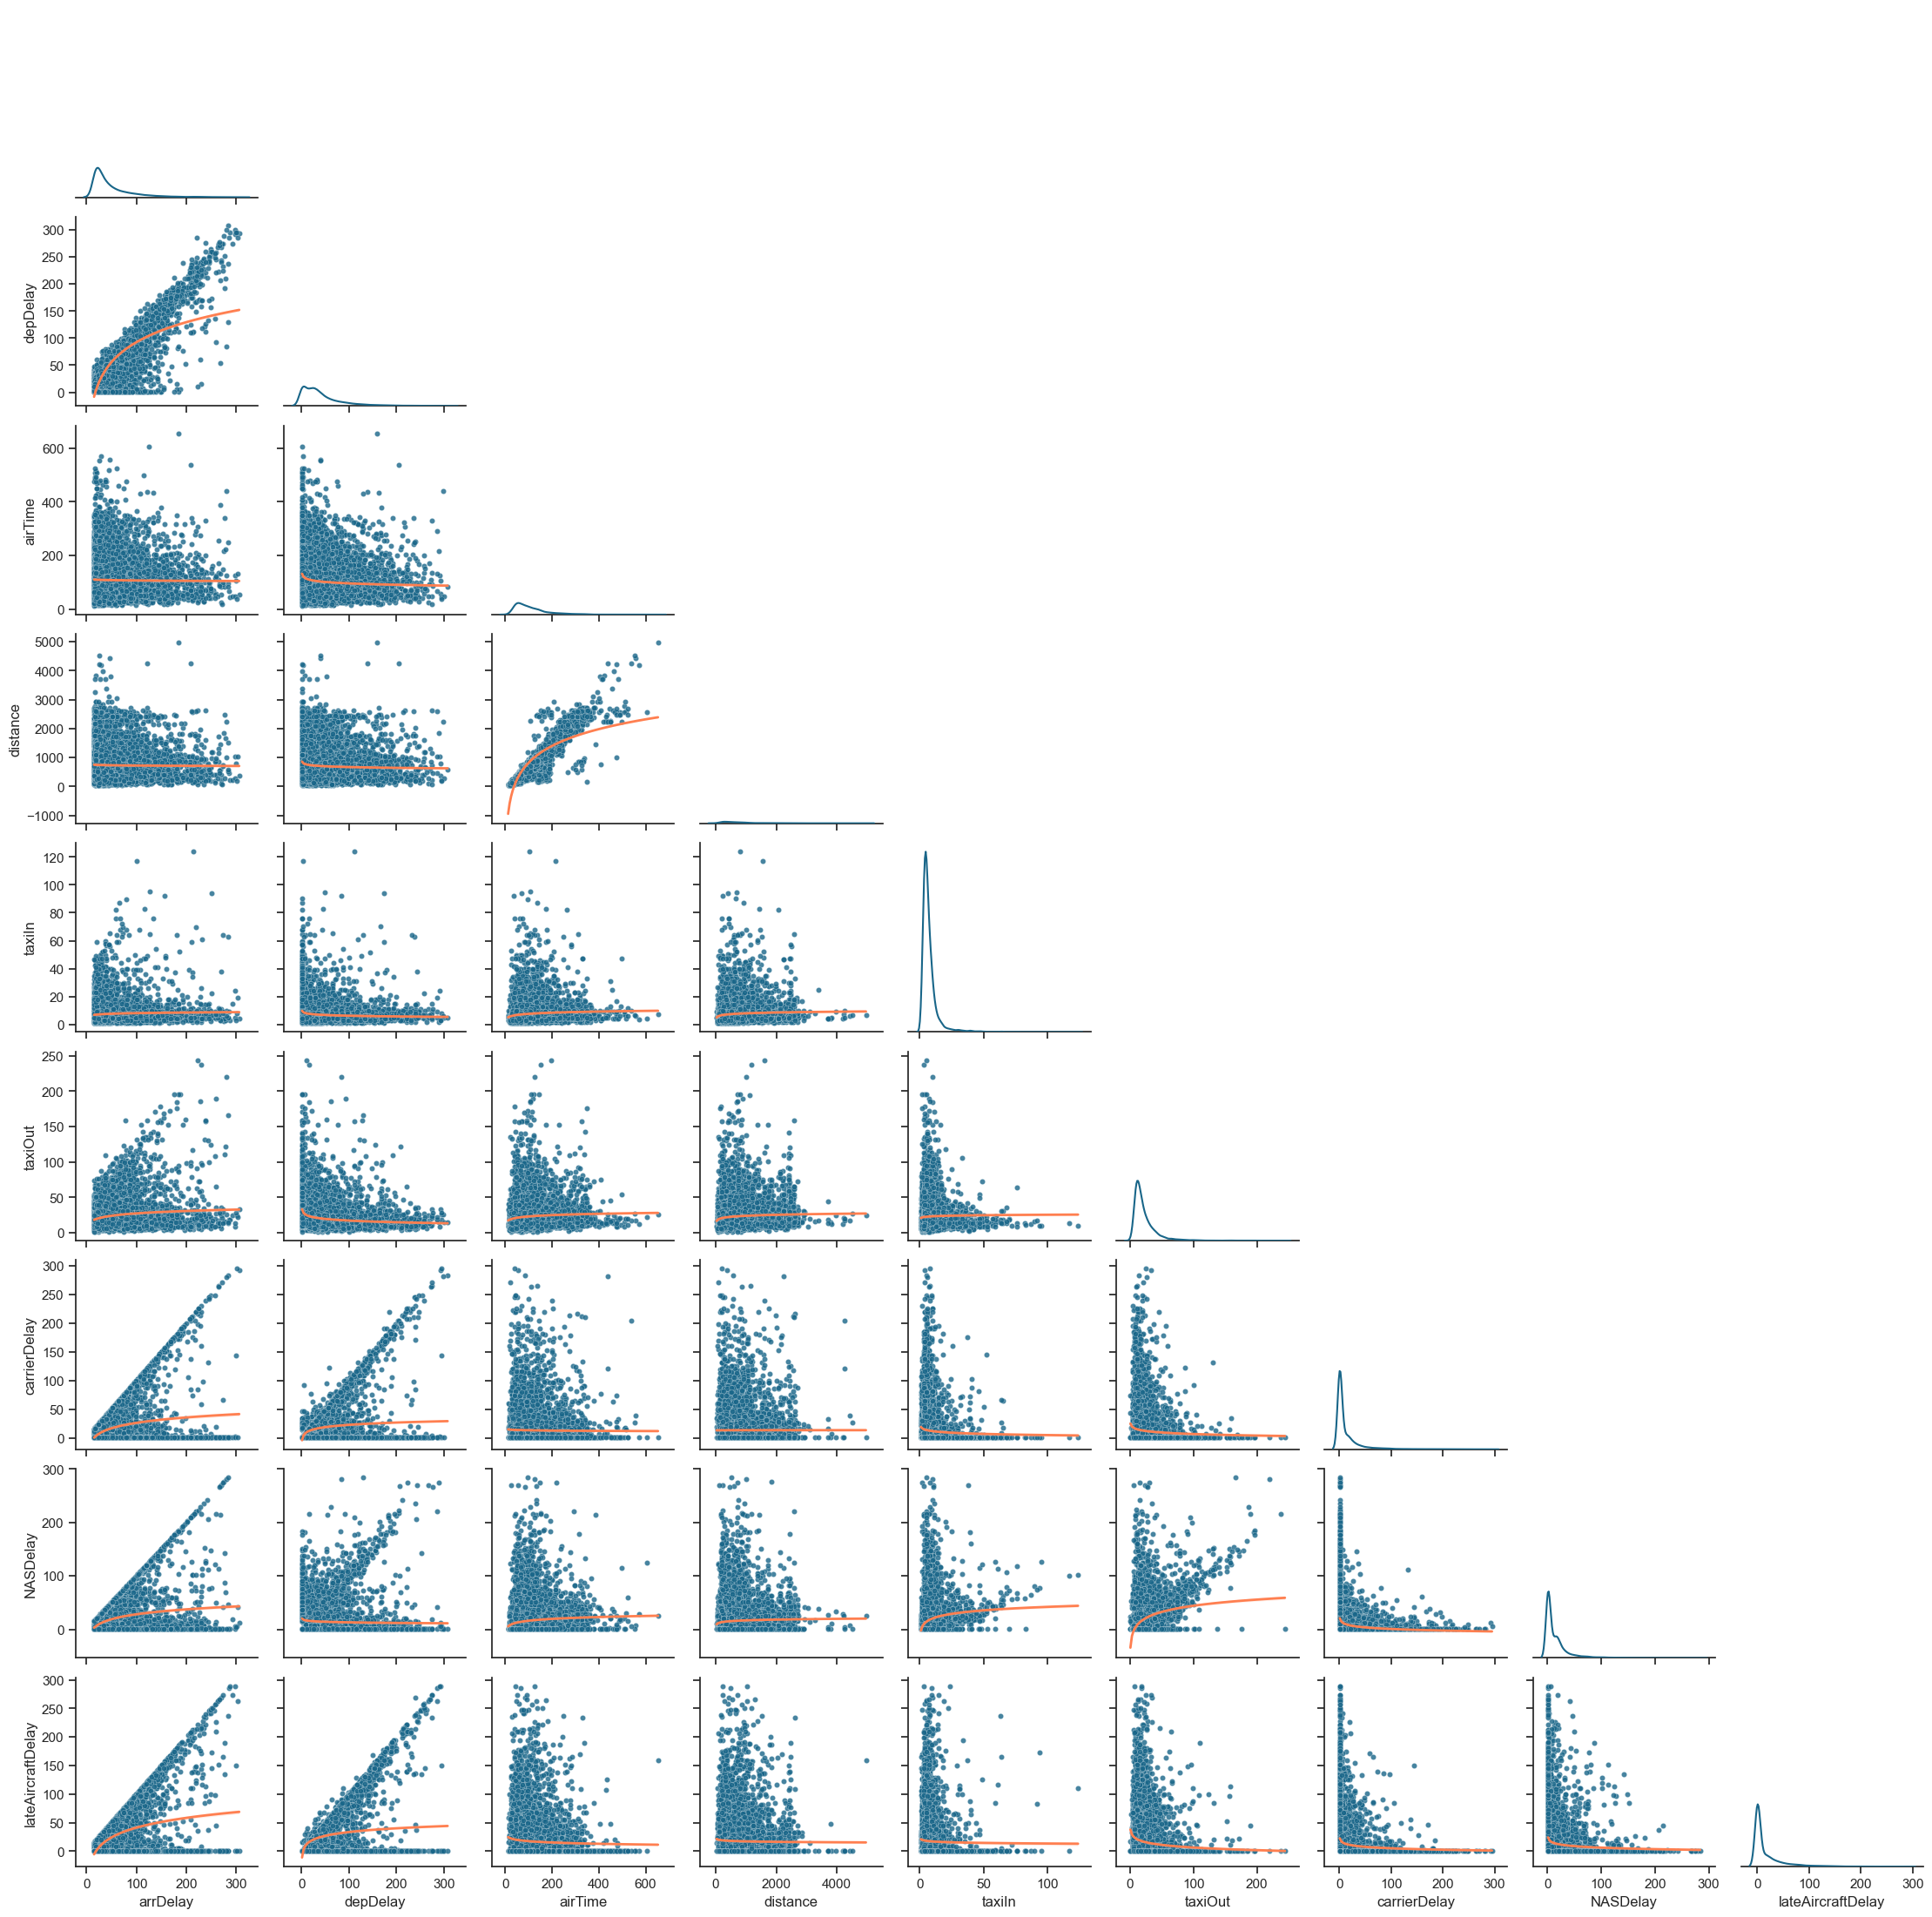

In [151]:
sample = np.random.choice(flight_delays_sample.shape[0], 10000, replace=False)
flight_delays_sample_small = flight_delays_sample.iloc[sample].copy()

sns.set(style='ticks')
g = sns.PairGrid(data = flight_delays_sample_small, vars=numeric_vars, corner=True, dropna=True)
g.map_diag(sns.kdeplot, color=BASE_COLOR);
g.map_offdiag(sns.regplot, fit_reg=True, y_jitter=0.1, x_jitter=0.1, truncate=True, logx=True, scatter_kws={'s':20, 'edgecolor':'white', 'lw':0.2}, line_kws={'color': 'coral', 'lw':2}, color=BASE_COLOR)
plt.show()

In [155]:
set_plot_defaults()

('#196689',
 (0.73278943, 0.36956954, 0.36476549),
 (0.85899928, 0.66937226, 0.6596292),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 'lightgrey',
 (0.35551826, 0.51744353, 0.73994642),
 (0.68441395, 0.73612771, 0.82136094),
 ['▼', '▲'])

**Observations from heatplot:**

- the log relationship between arrDelay and depDelay indicate that arrival delay grows slower as departure delay increase
- there is an interesting relationship between distance and airtime indicating that as the distance increase, airtime grows as well but at a slower rate

#### Confirm the relationship between departure delay and arrival day
To what extend does delays in departure airports cause delays in arrival airports ? Do we make up any time in the air ?

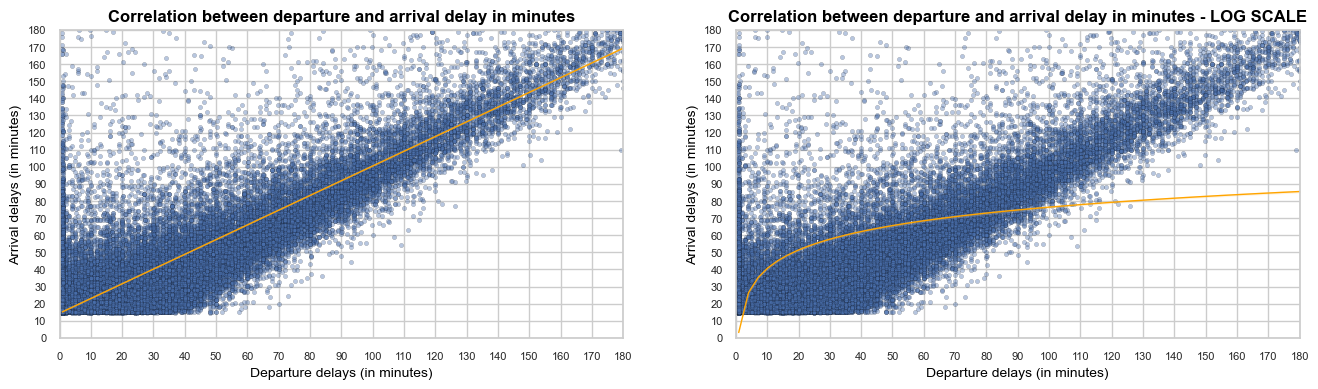

In [324]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4)) 

ticks = np.arange(0, int(flight_delays_sample['arrDelay'].max()+10), 10)

plt.subplot(1,2,1)
sns.regplot(x=flight_delays_sample['depDelay'], y=flight_delays_sample['arrDelay'], y_jitter=0.2, x_jitter=0.2, fit_reg=True, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Arrival delays (in minutes)')
plt.title('Correlation between departure and arrival delay in minutes')
plt.yticks(ticks, ticks)
plt.xticks(ticks, ticks)
plt.xlim(0,180)
plt.ylim(0,180)

plt.subplot(1,2,2)
sns.regplot(x=flight_delays_sample['depDelay'], y=flight_delays_sample['arrDelay'], fit_reg=True, logx=True, y_jitter=0.2, x_jitter=0.2, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Arrival delays (in minutes)')
plt.title('Correlation between departure and arrival delay in minutes - LOG SCALE')
plt.yticks(ticks, ticks)
plt.xticks(ticks, ticks)
plt.xlim(0,180)
plt.ylim(0,180)

plt.show()

When departure delay increase, arrival delay increase as well but at a lower rate.

Lets try to visilize this pattern a bit more clearer.

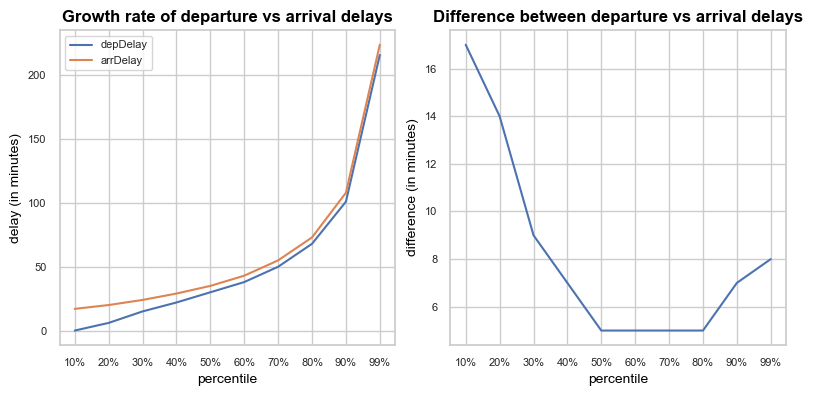

In [156]:
minute_intervals = flight_delays[['depDelay', 'arrDelay']].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).round(0)

# get only percentile fields
minute_intervals = minute_intervals.iloc[4:-1]

plt.subplot(1,2,1)
plt.plot(minute_intervals)
plt.title('Growth rate of departure vs arrival delays')
plt.xlabel('percentile')
plt.ylabel('delay (in minutes)')
plt.legend(['depDelay', 'arrDelay'])

plt.subplot(1,2,2)
minute_intervals['diff'] = minute_intervals['arrDelay'] - minute_intervals['depDelay']
plt.plot(minute_intervals['diff'])
plt.title('Difference between departure vs arrival delays')
plt.xlabel('percentile')
plt.ylabel('difference (in minutes)')

plt.tight_layout()
plt.show()

The biggest shrinkage of the gap between departure and arrival delay happens up to 50% percentile (30 minutes). 
The shrinkage continue until 90th percentile (100 minutes), but at a lower rate. After which, there are no more significant catch-up time.

When departure delay < 100 minutes, we have a chance to catch-up for lost time during the flight and minimize the delay

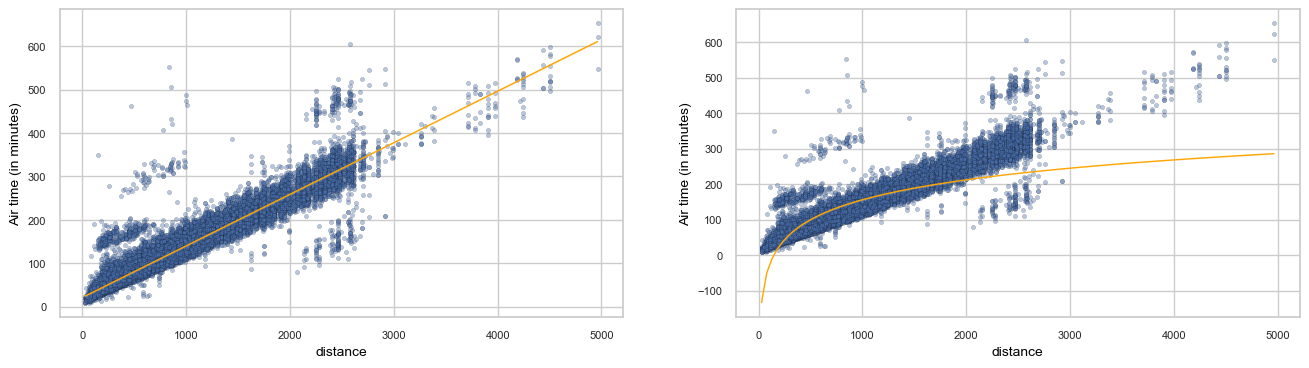

In [325]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4)) 

# ticks = np.arange(0, int(flight_delays_sample['arrDelay'].max()+10), 10)

plt.subplot(1,2,1)
sns.regplot(x=flight_delays_sample['distance'], y=flight_delays_sample['airTime'], y_jitter=0.2, x_jitter=0.2, fit_reg=True, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('distance')
plt.ylabel('Air time (in minutes)')
# plt.title('Correlation between departure and arrival delay in minutes')
# plt.yticks(ticks, ticks)
# plt.xticks(ticks, ticks)
# plt.xlim(0,180)
# plt.ylim(0,180)

plt.subplot(1,2,2)
sns.regplot(x=flight_delays_sample['distance'], y=flight_delays_sample['airTime'], fit_reg=True, logx=True, y_jitter=0.2, x_jitter=0.2, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('distance')
plt.ylabel('Air time (in minutes)')
# plt.title('Correlation between departure and arrival delay in minutes - LOG SCALE')
# plt.yticks(ticks, ticks)
# plt.xticks(ticks, ticks)
# plt.xlim(0,180)
# plt.ylim(0,180)

plt.show()

#### What is the relationship between carriers and airports they serve ?

In [245]:
cat_carrier['uniqueCarrier'][:10]

carrier_description
Southwest Airlines Co.                                                                 WN
American Airlines Inc.                                                                 AA
Delta Air Lines Inc.                                                                   DL
American Eagle Airlines Inc.                                                           MQ
United Air Lines Inc.                                                                  UA
Northwest Airlines Inc.                                                                NW
US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)    US
Skywest Airlines Inc.                                                                  OO
Expressjet Airlines Inc.                                                               XE
Atlantic Southeast Airlines                                                            EV
Name: uniqueCarrier, dtype: object

In [572]:
top_carrier = list(cat_carrier['uniqueCarrier'][:30])
top_carrier

['WN',
 'AA',
 'DL',
 'MQ',
 'UA',
 'NW',
 'US',
 'OO',
 'XE',
 'EV',
 'CO',
 'OH',
 'FL',
 'AS',
 'B6',
 'DH',
 'YV',
 'HP',
 '9E',
 'F9',
 'TZ',
 'HA',
 'AQ']

In [575]:
top_origin = list(origin['origin'][:30])
top_origin

['ATL',
 'ORD',
 'DFW',
 'EWR',
 'IAH',
 'LAX',
 'DEN',
 'PHX',
 'DTW',
 'LAS',
 'MSP',
 'PHL',
 'LGA',
 'JFK',
 'BOS',
 'CVG',
 'SFO',
 'CLT',
 'SLC',
 'IAD',
 'SEA',
 'MCO',
 'BWI',
 'MDW',
 'DCA',
 'CLE',
 'MIA',
 'FLL',
 'SAN',
 'TPA']

In [510]:
# test = flights.groupby(['uniqueCarrier', 'origin'], as_index=False)['flight_status'].value_counts()
test = flights.groupby(['uniqueCarrier', 'origin'])['flight_status'].value_counts().unstack().reset_index()
test = test.loc[(test['uniqueCarrier'].isin(top_carrier)) & (test['origin'].isin(top_origin))]
test = test.sort_values(by='delayed', ascending=False)
test

flight_status uniqueCarrier origin  cancelled   delayed  diverted   on_time
544                      DL    ATL    14965.0  221542.0    1541.0  691921.0
149                      AA    DFW    13380.0  182471.0    1472.0  609524.0
675                      EV    ATL    16228.0  155480.0    1095.0  356831.0
1212                     NW    DTW     7864.0  142938.0     944.0  355763.0
1733                     UA    ORD    10351.0  140707.0    1069.0  377604.0
1260                     NW    MSP     5376.0  132076.0    1122.0  382334.0
1142                     MQ    ORD    18523.0  119908.0     591.0  282964.0
192                      AA    ORD    11573.0  114707.0     951.0  301399.0
1081                     MQ    DFW    10618.0  100764.0     738.0  323916.0
1829                     US    PHL     6004.0   96340.0     618.0  192866.0
374                      CO    IAH     1860.0   94403.0     724.0  338611.0
910                      FL    ATL     3171.0   92032.0     814.0  252948.0
1690                     UA    DEN     5505.0   91222.0     749.0  311609.0
1782                     US    CLT     4139.0   90006.0     516.0  302905.0
1972                     XE    EWR    11491.0   88892.0     611.0  177439.0
1989                     XE    IAH     6060.0   83274.0    1114.0  355968.0
1886                     WN    LAS     2265.0   81896.0     623.0  276776.0
365                      CO    EWR     3345.0   75187.0     532.0  205373.0
1343                     OH    CVG     8366.0   72015.0     617.0  317743.0
1904                     WN    PHX     3202.0   65601.0     568.0  269001.0
1608                     OO    SLC     3776.0   63442.0     835.0  306611.0
304                      B6    JFK     2207.0   55826.0     662.0  144514.0
1749                     UA    SFO     2778.0   43026.0     406.0  182459.0
1030                     HP    PHX     1825.0   42365.0     359.0  156862.0
486                      DH    IAD     4704.0   41280.0     291.0  151232.0
1602                     OO    SFO     3961.0   40943.0     287.0  141995.0
1567                     OO    ORD     7061.0   39473.0     202.0  102791.0
1887                     WN    LAX     2838.0   38252.0     233.0  163420.0
1494                     OO    DEN     3495.0   38036.0     282.0  153725.0
564                      DL    CVG     2879.0   36731.0     383.0  158947.0
1830                     US    PHX     1194.0   34641.0     302.0  110493.0
173                      AA    LAX     1681.0   33461.0     379.0  119307.0
1537                     OO    LAX     2942.0   32208.0     229.0  210475.0
1715                     UA    LAX     2496.0   31195.0     298.0  142717.0
174                      AA    LGA     3851.0   29232.0     413.0   79205.0
651                      DL    SLC     1169.0   27125.0     346.0  146072.0
1706                     UA    IAD     2092.0   26651.0     221.0   99592.0
869                      F9    DEN      678.0   26355.0     169.0   91021.0
1118                     MQ    LGA     5054.0   26151.0     231.0   59733.0
1060                     MQ    BOS     4031.0   25115.0     128.0   62619.0
508                      DH    ORD     2901.0   25079.0     176.0   47932.0
1806                     US    LAS     1001.0   23105.0     170.0   62571.0
1378                     OH    JFK     3359.0   22243.0      96.0   36289.0
1014                     HP    LAS     1611.0   22000.0     148.0   73747.0
603                      DL    LGA     4338.0   21716.0     145.0   84536.0
598                      DL    JFK     1012.0   21277.0     140.0   44957.0
2141                     YV    IAD     2528.0   20458.0     136.0   45845.0
1775                     US    BOS     3342.0   20221.0     157.0   77430.0
170                      AA    JFK     1040.0   19106.0     176.0   46056.0
2184                     YV    ORD     3325.0   18252.0      82.0   33341.0
1381                     OH    LGA     3571.0   16478.0     115.0   38283.0
551                      DL    BOS     2345.0   

In [275]:
test = flight_delays_sample.loc[flight_delays_sample['uniqueCarrier'].isin(top_carrier)]
test

year  month  day  dayOfWeek         depTime         arrTime  \
23749259  2006      6   18          7 0 days 17:35:00 0 days 19:30:00   
27939977  2007      1   14          7 0 days 19:23:00 0 days 22:32:00   
27915853  2007      1    6          6 0 days 19:38:00 0 days 20:41:00   
638628    2003      2   14          5 0 days 17:33:00 0 days 18:39:00   
27952365  2007      1   18          4 0 days 20:25:00 0 days 22:56:00   
...        ...    ...  ...        ...             ...             ...   
9520034   2004      6   19          6 0 days 18:30:00 0 days 19:25:00   
9492816   2004      6    9          3 0 days 17:10:00 0 days 17:50:00   
31064964  2007      6   30          6 0 days 10:15:00 0 days 11:06:00   
4907899   2003     10    3          5 0 days 09:50:00 0 days 10:48:00   
20791939  2006      1    2          1 0 days 16:20:00 0 days 17:40:00   

         uniqueCarrier tailNum  actualElapsedTime  airTime  arrDelay  \
23749259            WN    N444                175    150.0      20.0   
27939977            WN    N421                129    114.0      17.0   
27915853            WN  N664WN                 63     53.0     136.0   
638628              WN    N793                 66     56.0      74.0   
27952365            WN    N207                270    245.0      30.0   
...                ...     ...                ...      ...       ...   
9520034             WN    N324                115    100.0      25.0   
9492816             WN    N519                 40     28.0      20.0   
31064964            WN  N270WN                 51     33.0      16.0   
4907899             WN    N510                118     80.0      28.0   
20791939            WN    N787                 80     60.0      75.0   

          depDelay origin dest  distance  taxiIn  taxiOut  cancelled  \
23749259      30.0    FLL  MDW    1166.0     5.0     20.0      False   
27939977      38.0    PHX  MCI    1044.0     9.0      6.0      False   
27915853     143.0    SMF  BUR     358.0     2.0      8.0      False   
638628        83.0    MDW  STL     251.0     4.0      6.0      False   
27952365      30.0    MDW  SEA    1733.0     6.0     19.0      False   
...            ...    ...  ...       ...     ...      ...        ...   
9520034       30.0    HOU  ABQ     759.0     5.0     10.0      False   
9492816       25.0    HOU  AUS     148.0     2.0     10.0      False   
31064964      10.0    DAL  AUS     189.0     4.0     14.0      False   
4907899        0.9    ABQ  LAS     487.0     8.0     30.0      False   
20791939      75.0    LAS  RNO     345.0     5.0     15.0      False   

         cancellationCode  diverted  carrierDelay  weatherDelay  NASDelay  \
23749259              NaN     False           7.0             0       0.9   
27939977              NaN     False           0.9             5       0.9   
27915853              NaN     False          16.0             0       0.9   
638628                NaN     False           0.9             0       0.9   
27952365              NaN     False           0.9             4       0.9   
...                   ...       ...           ...           ...       ...   
9520034               NaN     False           0.9             0       0.9   
9492816               NaN     False           3.0             0       0.9   
31064964              NaN     False           6.0             0       6.0   
4907899               NaN     False           0.9             0      28.0   
20791939              NaN     False          12.0             0       0.9   

          securityDelay  lateAircraftDelay  hour                date  \
23749259              0               13.0  17.0 2006-06-18 17:00:00   
27939977              0               12.0  19.0 2007-01-14 19:00:00   
27915853              0              120.0  19.0 2007-01-06 19:00:00   
638628                0                0.9  17.0 2003-02-14 17:00:00   
27952365              0               26.0  20.0 2007-01-18 20:00:00   
...                 ...                ...   .

In [598]:
origin_test = origin.reset_index().reset_index()
origin_test.index.name = 'index'
origin_test = origin_test[['index', 'origin']]
origin_test.head()

flight_status  index origin
index                      
0                  0    ATL
1                  1    ORD
2                  2    DFW
3                  3    EWR
4                  4    IAH

In [254]:
# test.drop(['on_time', 'diverted', 'cancelled'], axis=1, inplace=True) 

In [495]:
# plt.figure(figsize = [20,8])
# sns.catplot(data=test, x="uniqueCarrier", y='delayed', hue="origin", kind="bar")

In [576]:
df = flights[['uniqueCarrier', 'origin', 'arrDelay']].copy()
df['flight'] = 1
df = df.loc[(df['uniqueCarrier'].isin(top_carrier))]
df = df.loc[(df['origin'].isin(top_origin))]
df.head()

uniqueCarrier origin  arrDelay  flight
0             UA    ORD       0.0       1
1             UA    ORD       0.0       1
2             UA    ORD      23.0       1
9             UA    IAD       4.0       1
10            UA    IAD       0.0       1

In [577]:
df_heatmap = df.pivot_table(values='arrDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)
df_heatmap

origin               ORD        IAD        BOS        SAN        DEN  \
uniqueCarrier                                                          
UA             17.478991  12.920970  13.551191  11.647588  13.549794   
US             17.610764  10.188228  11.343653   9.629026  10.163684   
WN                   NaN   9.231451        NaN   8.827225  11.409133   
MQ             17.101181  19.692606  17.094946   4.863722        NaN   
NW             11.805757  10.130051  10.900510   8.244070  10.060638   
OO             17.841696  44.428570        NaN   6.223683  11.108603   
XE             18.229200  18.864733  11.699260   9.545455   9.286006   
TZ                   NaN        NaN  10.231224        NaN   8.639490   
DL             13.975321  12.036363  10.566560   6.816906   9.217381   
EV             15.890930  14.752599  14.280342   7.015801  10.007019   
FL                   NaN  15.598913  15.554117   7.120527  10.450383   
HP             13.461945  12.772444  11.294967   7.792691   8.452303   
AA             17.566826   9.255795  13.389973  11.584856  12.483464   
AS             20.418501  11.378070  17.287157  12.041904  12.147892   
B6             25.361603  13.210669  13.145349  10.851105  15.947720   
CO             24.166660  14.365749  18.988020   8.918558  10.959947   
DH             21.931667  12.987487  14.281980  12.710660        NaN   
HA                   NaN        NaN        NaN  10.892238        NaN   
OH             18.418037  14.958347  17.179611        NaN   9.580543   
F9                   NaN        NaN        NaN   8.353834  10.983106   
YV             27.432539  22.235676  24.203979   7.460613  13.966340   
AQ                   NaN        NaN        NaN   5.341270        NaN   
9E                   NaN  12.475758  16.399649        NaN  15.056603   

origin               CLE        TPA        EWR        ATL        DTW  \
uniqueCarrier                                                          
UA             14.504286  11.169587  16.772829  16.156788  12.516403   
US              8.910094  10.874400  15.850188  14.390803  10.048052   
WN              9.633505   8.450674        NaN        NaN   9.864969   
MQ             17.508909        NaN  20.482195  25.821930  19.780128   
NW              9.425014   9.932987  13.438102  11.487654  14.449804   
OO             22.503832        NaN  39.268250  15.999567  21.103504   
XE             10.472089   8.067779  20.982500  14.323172  19.402218   
TZ                   NaN  51.000000  17.011990        NaN        NaN   
DL              9.797674  10.657444  15.280509  13.054417  12.518391   
EV             18.084444   6.949562  26.458860  16.911604  17.761122   
FL                   NaN  11.089067  26.110098  16.002296  10.863717   
HP              9.530844  11.430684  10.931765  11.860785   8.128143   
AA             13.284900  11.730899  17.798714  15.654778  11.630415   
AS                   NaN        NaN  15.612474        NaN        NaN   
B6                   NaN  14.794068  23.749187   4.946593        NaN   
CO             11.099424  13.650225  16.049498  21.027126  14.028740   
DH             11.711562  10.614961  16.295774  13.657438  10.967140   
HA                   NaN        NaN        NaN        NaN        NaN   
OH             13.695261  12.437859  19.269175  17.690622  12.074643   
F9                   NaN   7.176983        NaN   9.746006   8.845920   
YV             18.062132        NaN  20.872559  20.379015  16.571329   
AQ                   NaN        NaN        NaN        NaN        NaN   
9E             13.237288        NaN        NaN  21.820225  12.829616   

origin               LAS        DFW        PHL        SFO        PHX  \
uniqueCarrier                                                          
UA             13.158788  13.977459  17.147573  11.059494  12.303050   
US             13.618913  12.814882  18.990744  11.277735  12.152583   
WN             11.409045        NaN  15.433148  12.266010   9.476336   
MQ             12.483399  13.138775  1

In [482]:
# df_heatmap = df_heatmap[df_heatmap.sum(axis=0).sort_values(ascending = False).index]
# df_heatmap = df_heatmap.loc[:, df_heatmap.min().sort_values().index]
# df_heatmap

origin           BOS    CLT    PHL    DEN    EWR     DFW    CVG    LAS    SFO  \
uniqueCarrier                                                                   
9E               3.0    1.0    4.0    1.0    NaN     1.0    3.0    NaN    NaN   
AA             129.0    9.0   64.0   66.0   70.0  1229.0    NaN   53.0   92.0   
AS               4.0    NaN    NaN   20.0   11.0     6.0    NaN   31.0   28.0   
B6              72.0    9.0    NaN    8.0   20.0     NaN    NaN   24.0    3.0   
CO              66.0    NaN   21.0   23.0  548.0    31.0    NaN   46.0   24.0   
DH              39.0   14.0    9.0    NaN    9.0     NaN   68.0    NaN    2.0   
DL             113.0   12.0   49.0   30.0   45.0    64.0  256.0   57.0   40.0   
EV               1.0    4.0    1.0    4.0    1.0   117.0   49.0    2.0    4.0   
F9               NaN    NaN    3.0  205.0    NaN     7.0    NaN    9.0    6.0   
FL              52.0   13.0   52.0    7.0   16.0    34.0    NaN    2.0    2.0   
HP              13.0    NaN    9.0   11.0    6.0    12.0    NaN  159.0   23.0   
MQ             177.0   37.0   17.0    NaN   38.0   671.0   36.0    3.0    6.0   
NW              24.0   24.0   55.0   32.0   40.0    16.0    1.0   36.0   23.0   
OH              87.0   20.0   17.0    3.0    6.0     6.0  484.0    NaN    NaN   
OO               NaN    NaN    2.0  241.0    3.0    30.0    7.0   25.0  312.0   
UA              72.0   17.0   58.0  627.0   41.0    25.0    5.0   90.0  288.0   
US             147.0  657.0  646.0   30.0   24.0    39.0    NaN  159.0   42.0   
WN               NaN    NaN  102.0   33.0    NaN     NaN    NaN  536.0    1.0   
XE               1.0   44.0   17.0    1.0  594.0    11.0   41.0    1.0    1.0   
YV               3.0   99.0   10.0   43.0    5.0     3.0    NaN   25.0    1.0   

origin           IAD    PHX    LAX    LGA    IAH    MSP    SLC     DTW    JFK  \
uniqueCarrier                                                                   
9E               2.0    NaN    NaN    4.0    NaN   56.0    NaN    85.0    NaN   
AA              19.0   41.0  212.0  208.0   37.0   44.0   11.0    31.0  112.0   
AS               2.0   20.0   76.0    NaN    NaN    NaN    NaN     NaN    NaN   
B6              43.0    2.0    NaN   21.0    NaN    NaN    7.0     NaN  345.0   
CO               1.0   24.0   48.0   37.0  661.0   11.0    7.0    13.0    4.0   
DH             279.0    NaN    2.0    5.0    NaN    NaN    NaN    10.0   13.0   
DL              27.0   11.0  103.0  171.0   20.0   22.0  198.0    23.0  152.0   
EV               NaN    1.0    4.0    3.0    7.0   10.0   40.0     8.0    4.0   
F9               NaN    7.0   12.0    4.0    2.0    3.0    5.0     4.0    NaN   
FL              32.0    2.0    7.0   55.0    NaN   17.0    NaN     6.0    NaN   
HP               8.0  264.0   18.0    NaN   10.0    8.0    3.0     4.0   10.0   
MQ              13.0    NaN   73.0  158.0    2.0    5.0    NaN    23.0   68.0   
NW              19.0   25.0   44.0   58.0   16.0  849.0   14.0  1001.0   10.0   
OH              27.0    NaN    NaN  119.0    5.0   17.0    3.0    12.0  141.0   
OO               NaN   18.0  222.0    NaN   24.0    6.0  431.0     3.0    NaN   
UA             187.0   49.0  230.0   62.0   13.0   38.0   22.0    25.0   30.0   
US               9.0  222.0   41.0   99.0   14.0    7.0    4.0    18.0    9.0   
WN               3.0  442.0  281.0    NaN    6.0    NaN   86.0    40.0    NaN   
XE              31.0    4.0   20.0   14.0  569.0   20.0   11.0    18.0    4.0   
YV             151.0   92.0    4.0    2.0    7.0    2.0    NaN     7.0    7.0   

origin           ORD     ATL  
uniqueCarrier                 
9E               NaN     NaN  
AA             805.0    67.0  
AS              11.0     NaN  
B6               6.0     NaN  
CO              54.0    45.0  
DH             159.0     8.0  
DL              33.0  1504.0  
EV               4.0  1030.0  
F9               NaN     6.0  
FL               NaN   628.0  
HP               4.0     7.0  
MQ             881.0    14.0  


In [578]:
# df_heatmap = df_heatmap[df_heatmap.sum(axis=0).sort_values(ascending = True).index]
# first reorder origin airports low to high
df_heatmap = df_heatmap.loc[:, df_heatmap.max().sort_values().index]
# then reorder carriers low to high
df_heatmap = df_heatmap.loc[df_heatmap.max(axis=1).sort_values().index, :]
df_heatmap

origin               SAN        DCA        SLC        IAH        DEN  \
uniqueCarrier                                                          
AQ              5.341270        NaN        NaN        NaN        NaN   
HA             10.892238        NaN        NaN        NaN        NaN   
HP              7.792691   8.367865   7.346715   9.880851   8.452303   
WN              8.827225        NaN   9.437925   9.033006  11.409133   
NW              8.244070   9.394012   7.581088   8.292958  10.060638   
F9              8.353834   8.059566   8.903737  10.279883  10.983106   
AA             11.584856  11.442102  12.045555  13.212040  12.483464   
UA             11.647588  13.132609  15.283435  11.597020  13.549794   
DL              6.816906  10.195590   8.083598  13.409030   9.217381   
US              9.629026  10.974460   9.720917  11.003005  10.163684   
AS             12.041904   9.967676        NaN        NaN  12.147892   
XE              9.545455  11.744657   7.754977  10.676388   9.286006   
9E                   NaN  12.982891  10.929293  13.257414  15.056603   
OH                   NaN  13.568425   9.138423  12.191257   9.580543   
MQ              4.863722  13.990677        NaN  11.967204        NaN   
FL              7.120527  13.604868        NaN        NaN  10.450383   
EV              7.015801   9.275758  12.561930  14.216959  10.007019   
YV              7.460613  14.776649   7.476505  15.352672  13.966340   
DH             12.710660  10.570588        NaN        NaN        NaN   
CO              8.918558  14.250161   9.986714  12.376544  10.959947   
OO              6.223683        NaN   8.820588   8.813302  11.108603   
TZ                   NaN   9.536769        NaN        NaN   8.639490   
B6             10.851105        NaN   7.718902        NaN  15.947720   

origin               MIA        MSP        LAS        DFW        MCO  \
uniqueCarrier                                                          
AQ                   NaN        NaN   4.206226        NaN        NaN   
HA                   NaN        NaN   8.355148        NaN        NaN   
HP              8.401261   8.074298  11.758499   9.344851  11.592668   
WN                   NaN        NaN  11.409045        NaN   8.783546   
NW              8.836961  12.654429  10.506298   7.874204   9.520189   
F9                   NaN   8.682824   8.845463  10.496153   8.897898   
AA             15.951706  13.939718  13.338039  13.750261  13.648806   
UA             10.716426  14.078367  13.158788  13.977459  11.544671   
DL             13.400758   8.876783  10.267817   9.315981  10.979230   
US             10.109777  10.882884  13.618913  12.814882  12.534774   
AS             13.015393        NaN  15.933442  15.288021  15.150497   
XE              8.199685  16.173016  10.104418  11.193089   7.678899   
9E                   NaN  12.292022        NaN  12.992920        NaN   
OH             13.877174  11.199403        NaN  12.880454  12.141866   
MQ             12.825901  15.713881  12.483399  13.138775  11.836764   
FL             14.124567  12.440568   9.050791  14.403425  12.170606   
EV              0.000000  14.519732  16.512690   9.447033  11.432331   
YV                   NaN  11.973866  11.405984  13.019726        NaN   
DH                   NaN        NaN   8.818500        NaN  11.878630   
CO             12.833610  14.159916  10.318122  16.878281  14.108211   
OO                   NaN  13.578793  11.281424   8.876926        NaN   
TZ              9.931490   7.763877  10.482919  10.151588   8.493683   
B6                   NaN        NaN  11.532565        NaN  17.378809   

origin               FLL        CVG        PHX        SEA        DTW  \
uniqueCarrier                                                          
AQ                   NaN        NaN        NaN        NaN        NaN   
HA                   NaN        NaN   6.831126  12.024553        NaN   
HP             12.920923        NaN  10.466268   8.731931   8.128143   
WN              9.527945        NaN   

In [514]:
# df_heatmap.iloc[np.argsort(np.diag(df_heatmap))]
# df_heatmap

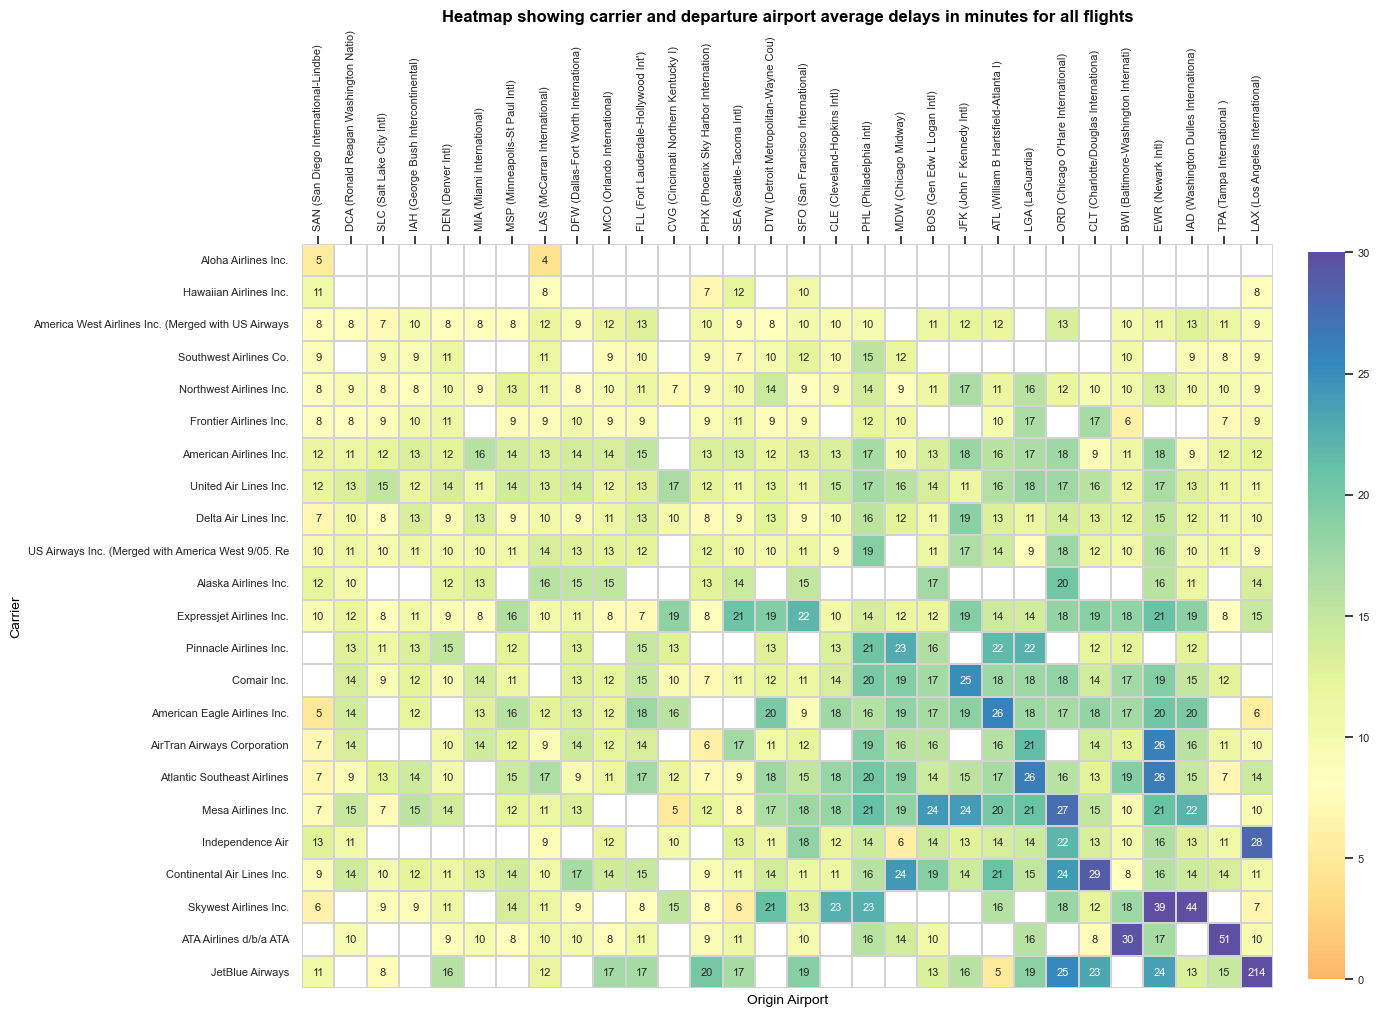

In [594]:
plt.figure(figsize = [15,15])

g = sns.heatmap(df_heatmap, center=8, cmap='Spectral', linewidths=0.003, linecolor='lightgrey', square=True, mask=df_heatmap < 1, annot=True, fmt=".0f", vmax=30, vmin=0, 
                cbar_kws={"orientation": "vertical", "pad": 0.03, "shrink": 0.5})

# add descriptions to xticks
xticks = g.get_xticks()
xlabels = []
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):  
    city = '{} ({})'.format(label.get_text(), airports.loc[label.get_text()]['airport'][:30])
    xlabels.append(city)
plt.xticks(xticks, xlabels, rotation=90)

# add descriptions to yticks
yticks = g.get_yticks()
ylabels = []
locs, labels = plt.yticks()
for loc, label in zip(locs,labels):  
    carrier = '{}'.format(carriers.loc[label.get_text()]['carrier_description'][:50])
    ylabels.append(carrier)
plt.yticks(yticks, ylabels, rotation=360)

# put xlabels on top
plt.title('Heatmap showing carrier and departure airport average delays in minutes for all flights')
g.set(xlabel=" ", ylabel=" ")
g.xaxis.tick_top()
plt.xlabel('Origin Airport')
plt.ylabel('Carrier')
plt.tight_layout()
plt.show()

- Left side of heat plot have lower average delays than right side of the heat plot. 
- The bottom right quadrant contains the carriers and airports with most delays.
- Overall the top airlines that were flagged in Univariate anayisis, have lower average and consist delays, independent of the location. They are doing well actually.
- It seems like that it's more the smaller independent carriers that caused delays at specifically some airports
- the fact that the same carrier does well at airports in left quadrant, but worse at others, it must be a location think where some carriers have lower priority ?

Next steps:
- take carriers and locations in trouble quadrant and
  - what are top reasons for these higher than average delays ? Is it carrier or airport at fault ?
  
- seasonal:
  - seasonality by airport - does the pattern occur in all airports
  - day of week the quitest by airport

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!



## References
- [white text in pie chart](https://www.tutorialspoint.com/how-to-change-autopct-text-color-to-be-white-in-a-pie-chart-in-matplotlib)
- [interpretting acf and pacf graphs](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
- [formating xaxis date labels](https://stackoverflow.com/questions/56638648/seaborn-barplot-and-formatting-dates-on-x-axis)
- [annotate barplot](https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)
- [annoate barplot vertical vs horizontal](https://www.kaggle.com/code/asimislam/tutorial-annotate-placing-numbers-on-plots)